In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
from datetime import datetime
from collections import defaultdict
import itertools
style.use('fivethirtyeight')
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.3f}'.format
%matplotlib inline  

In [3]:
#get price bins
def PriceRange(priceArray):
    #Create price bins for both datasets
    bins = [0, 300000, 650000]
    priceRange_dict = {1:'Low',2:'Mid',3:'High'}
    return list(map(lambda x:priceRange_dict[x],np.searchsorted(bins,priceArray)))

In [4]:
prop_type_dict = {
    '1 - 1 1/2 Storey Semi-Detached' : 'House' ,
    '1 - 1 1/2 Storey Terraced' : 'House',
    '2 - 2 1/2 Storey Semi-Detached' : "House", 
    '2 - 2 1/2 Storey Terraced' : 'House',
    'Condominium/Apartment' : 'Condominium',
    'Detached' : "House", 
    'Flat' : "Condominium",
    'Low-Cost Flat' : "Condominium"
}

# NAPIC

In [4]:
df_napic_master = pd.read_pickle('../data/interim/df_napic-14-3-2018')
df_napic_master["year_month"] = df_napic_master.TKH_NILAI.dt.to_period('M')

# Too many missing values
df_napic_master.drop('KLASIFIKASI_KAW', inplace=True, axis=1)
# for c in df_napic_master.columns:
#     if df_napic_master[c].dtype == 'object':
#         df_napic_master = df_napic_master[df_napic_master[c].notnull()].copy()
# filter out size using the same rule as BIS. Ref: https://www.bis.org/ifc/publ/ifcb44i.pdf
df_napic_master= df_napic_master[(df_napic_master['LUAS_LOT_BGN'] > 21) & (df_napic_master['LUAS_LOT_BGN'] < 10000)].copy()
df_napic_master= df_napic_master[(df_napic_master['LUAS_LOT'] > 21) & (df_napic_master['LUAS_LOT'] < 10000)].copy()

#filter before 2013 - Propwall has 2013 till 2017
df_napic_master = df_napic_master[df_napic_master['year'] > 2012].copy()

df_napic_master['quarter'] = ((df_napic_master['month']-1)//3+1)

df_napic_master['year-quarter'] = df_napic_master['year'].astype(int).astype(str) + '-' \
                                    + df_napic_master['quarter'].astype(int).astype(str)

df_napic_master['STATE'] = df_napic_master['STATE'].map(lambda x: 'Selangor' if x in ['selangor','WP Putrajaya'] else x)

df_napic_master['State_Category'] = df_napic_master['STATE'].map(lambda x:'Others' if x not in ['Kuala Lumpur','Selangor']
                                                else x)
df_napic_master['price_bins'] = PriceRange(df_napic_master['HARGA_B'])
df_napic_master['House_type'] = df_napic_master['PRO_TYPE'].map(prop_type_dict)

df_napic_SecondaryMarket = df_napic_master[df_napic_master['PM_PERTAMA'] == 'T'].copy()
#choose KL
df_napicKL = df_napic_SecondaryMarket[df_napic_SecondaryMarket['STATE'] == 'Kuala Lumpur'].copy()

#select condo
highrise_arr = ['Condominium/Apartment', 'Flat']
df_napicKL = df_napicKL[df_napicKL['PRO_TYPE'].isin(highrise_arr)].copy()
df_napicSel = df_napic_SecondaryMarket[(df_napic_SecondaryMarket['STATE'] == 'Selangor')&
                         (df_napic_SecondaryMarket['PRO_TYPE'].isin(highrise_arr))].copy()

In [5]:
df_star = pd.read_csv('../data/processed/Propwall_Report_ForSale-28-3-18.csv')
# Load Property to District mapping
df_district = pd.read_excel('../data/external/kl_sel_districted.xlsx')
# Join the two set using Location_property as key
df_star = df_star.join(df_district, on='Location_property')
#add column of quarter and year-quarter
df_star['quarter'] = ((df_star['month']-1)//3+1)

df_star['year-quarter'] = df_star['year'].astype(str) + '-' + df_star['quarter'].astype(str)
df_star['State'] = df_star['State'].map(lambda x:'Selangor' if x == 'Petaling Jaya' else x)
df_star['State_Category'] = df_star['State'].map(lambda x:'Others' if x not in ['Kuala Lumpur','Selangor']
                                                else x)
df_star['price_bins'] = PriceRange(df_star['price']) 
df_star['year'] = df_star['year'].astype(int)
#choose only condo for kl and Selangor
df_starKL = df_star[(df_star['State'] == 'Kuala Lumpur')
                   & (df_star['Type'] == 'Condominium')].copy()

df_starSel = df_star[(df_star['State'] == 'Selangor')
                   & (df_star['Type'] == 'Condominium')].copy()

In [6]:
df_star['price'].mean()

709003.7470422757

In [35]:
type_hakmilik = [i for i in df_napicKL['JENIS_HAKMILIK'] if i not in ['Pajakan Mukim','Mukim Mining Lease',
                                                                     'Entry Daerah Registry','Akuan Menerima Tuntutan']]
df_napicKL[df_napicKL['JENIS_HAKMILIK'].isin(type_hakmilik)].groupby('year-quarter')['HARGA_B'].median()

year-quarter
2013.0-1.0    460000
2013.0-2.0    500000
2013.0-3.0    490000
2013.0-4.0    545000
2014.0-1.0    470000
2014.0-2.0    510000
2014.0-3.0    535000
2014.0-4.0    519000
2015.0-1.0    525000
2015.0-2.0    510000
2015.0-3.0    525000
2015.0-4.0    507500
2016.0-1.0    530000
2016.0-2.0    550000
2016.0-3.0    550000
2016.0-4.0    530000
Name: HARGA_B, dtype: int64

In [ ]:
#average of prices in KL and Selangor by year-quarter

In [17]:
df_napic_SecondaryMarket['STATE'].unique()

array(['Sabah', 'Sarawak', 'Selangor', 'Kedah', 'Perak', 'Pulau Pinang',
       'Pahang', 'Terengganu', 'Kelantan', 'Kuala Lumpur', 'Melaka',
       'Negeri Sembilan', 'Johor', 'Perlis', 'WP Labuan'], dtype=object)

In [21]:
df_napic_SecondaryMarket[df_napic_SecondaryMarket['STATE'].isin(['Selangor','Kuala Lumpur'])]\
.groupby(['STATE','year-quarter'])\
['HARGA_B'].mean().reset_index()\
.to_excel('../data/excel/AveragePriceNAPIC_KlSel_YearQ.xlsx')

In [24]:
df_star[df_star['State'].isin(['Selangor','Kuala Lumpur'])]\
.groupby(['State','year-quarter'])\
['price'].mean().reset_index()\
.to_excel('../data/excel/AveragePriceStar_KlSel_YearQ.xlsx')

In [ ]:
#number of listings by year-quarter

In [7]:
#numberlisting by year-quarter
pd.Series(df_napic_SecondaryMarket.groupby('year-quarter')\
          ['STATE'].count(),name = 'numtransctions')\
        .to_excel('../data/excel/Numtransactions_NAPIC_YearQ.xlsx')

In [15]:
df_star.groupby('year-quarter')\
['Location_property'].count()\
.to_excel('../data/excel/Numtransactions_Star_YearQ.xlsx')

In [31]:
#numberlisting by state Category
numlisting_stateC = df_napic_master.groupby(['State_Category','year-quarter'])['STATE'].count().reset_index().values

#numberlisting by year-quarter
numlisting_yearQ = df_napic_master.groupby(['year-quarter'])['STATE'].count().reset_index().values

df_temp = pd.DataFrame([[i[0],i[1],round((i[2]/dict(numlisting_yearQ)[i[1]])*100,2)] for i in numlisting_stateC])
df_temp.columns = ['State_Category','year-quarter','PercentageCount']
df_temp.to_excel('../data/excel/PercentageCount_ByStateC_NAPIC.xlsx')

In [11]:
df_napic_SecondaryMarket.groupby(['price_bins','year'])['HARGA_B'].mean().reset_index()\
.to_excel('../data/excel/YearlyAveragePrice_ByPriceBins_NAPIC.xlsx')

In [ ]:
#By price Bins

In [25]:
df_napic_priceBins = df_napic_SecondaryMarket.groupby(['price_bins','year-quarter'])['HARGA_B'].median().reset_index()
#.to_excel('../data/excel/YearlyMedianPrice_ByPriceBins_NAPIC.xlsx')

df_napic_priceBins_pivot = df_napic_priceBins.pivot_table(columns = 'price_bins',values = 'HARGA_B', index = 'year-quarter')\
.rename(columns = {'High':'NAPIC_High','Mid':'NAPIC_Mid','Low':'NAPIC_Low'})


df_star_priceBins = df_star.groupby(['price_bins','year-quarter'])['price'].median().reset_index()
#.to_excel('../data/excel/YearlyAveragePrice_ByPriceBins_Star.xlsx')

df_star_priceBins_pivot = df_star_priceBins.pivot_table(columns = 'price_bins',values = 'price', index = 'year-quarter')\
.rename(columns = {'High':'Star_High','Mid':'Star_Mid','Low':'Star_Low'})

df_priceBins_pivot_merged = df_napic_priceBins_pivot.merge(df_star_priceBins_pivot,left_index = True, right_index = True)

In [42]:
for i in ['High','Mid','Low']:
    df_priceBins_pivot_merged['Correlation_' + i] = \
    df_priceBins_pivot_merged['NAPIC_' + i ].corr(df_priceBins_pivot_merged['Star_' + i])

In [44]:
df_priceBins_pivot_merged
df_priceBins_pivot_merged.to_excel('../data/excel/Comparison_priceBins_NAPICStar.xlsx')

In [14]:
from scipy import stats

In [39]:
pandadf_list = []
for i in ['High','Mid','Low']:
    df_temp = df_napic_SecondaryMarket[df_napic_SecondaryMarket['price_bins'] == i].copy()
    df_temp['zscore_Price'] = stats.zscore(np.array(df_temp['HARGA_B']))
    df_tempSeries = df_temp.groupby('year-quarter')['zscore_Price'].mean()\
                    .reset_index()
    df_tempSeries['price_bins'] = 'NAPIC_' + i
    pandadf_list.append(df_tempSeries)

df_napic_zscore_priceBins = pd.concat(pandadf_list).pivot_table(columns = 'price_bins',values = 'zscore_Price',
                                   index = 'year-quarter')

df_napic_zscore_priceBins.to_excel('../data/excel/NAPIC_yearQ_zscore.xlsx')

In [43]:
pandadf_list = []
for i in ['High','Mid','Low']:
    df_temp = df_star[df_star['price_bins'] == i].copy()
    df_temp['zscore_Price'] = stats.zscore(np.array(df_temp['price']))
    df_tempSeries = df_temp.groupby('year-quarter')['zscore_Price'].mean()\
                    .reset_index()
    df_tempSeries['price_bins'] = 'star_' + i
    pandadf_list.append(df_tempSeries)

In [44]:
df_star_zscore_priceBins = pd.concat(pandadf_list).pivot_table(columns = 'price_bins',values = 'zscore_Price',
                                   index = 'year-quarter')

In [46]:
df_star_zscore_priceBins.to_excel('../data/excel/Star_yearQ_zscore.xlsx')

In [ ]:
#By House Type

In [51]:
df_napic_housetype = df_napic_SecondaryMarket.groupby(['House_type','year-quarter'])['HARGA_B'].median().reset_index()
df_napic_housetype_pivot = df_napic_housetype.pivot_table(columns = 'House_type',values = 'HARGA_B',index = 'year-quarter')\
.rename(columns = {'Condominium':'NAPIC_Condominium','House':'NAPIC_House'})
df_napic_housetype_pivot 

House_type    NAPIC_Condominium  NAPIC_House
year-quarter                                
2013-1                   190000       229800
2013-2                   200000       246000
2013-3                   210000       250000
2013-4                   228000       255000
2014-1                   180000       250000
2014-2                   200000       260000
2014-3                   205000       263155
2014-4                   205000       255000
2015-1                   208000       270000
2015-2                   210000       275000
2015-3                   215000       279944
2015-4                   220000       280000
2016-1                   230000       285000
2016-2                   250000       300000
2016-3                   245000       304670
2016-4                   230000       295000

In [48]:
df_star_housetype = df_star.groupby(['Type','year-quarter'])['price'].median().reset_index()
df_star_housetype_pivot = df_star_housetype.pivot_table(columns = 'Type',values = 'price',index = 'year-quarter')\
.rename(columns = {'Condominium':'Star_Condominium','House':'Star_House'})
df_star_housetype_pivot

Type          Star_Condominium  Star_House
year-quarter                              
2013-1             480,000.000 838,000.000
2013-2             480,000.000 830,000.000
2013-3             500,000.000 830,000.000
2013-4             500,000.000 850,000.000
2014-1             500,000.000 830,000.000
2014-2             515,000.000 820,000.000
2014-3             530,000.000 820,000.000
2014-4             505,000.000 820,000.000
2015-1             500,000.000 820,000.000
2015-2             500,000.000 820,000.000
2015-3             490,000.000 800,000.000
2015-4             480,000.000 800,000.000
2016-1             480,000.000 820,000.000
2016-2             480,000.000 775,000.000
2016-3             460,000.000 770,000.000
2016-4             458,000.000 750,000.000
2017-1             458,000.000 790,000.000
2017-2             460,000.000 790,000.000
2017-3             450,000.000 798,000.000
2017-4             450,000.000 799,000.000

In [54]:
df_housetype_pivot_merged = df_napic_housetype_pivot.merge(df_star_housetype_pivot,left_index = True, right_index = True)

In [55]:
for i in ['Condominium','House']:
    df_housetype_pivot_merged['Correlation_' + i] = \
    df_housetype_pivot_merged['NAPIC_' + i ].corr(df_housetype_pivot_merged['Star_' + i])

In [57]:
df_housetype_pivot_merged
df_housetype_pivot_merged.to_excel('../data/excel/Comparison_housetype_NAPICStar.xlsx')

In [ ]:
#By State Category

In [6]:
df_napic_statetype = df_napic_SecondaryMarket.groupby(['State_Category','year-quarter'])['HARGA_B'].median().reset_index()
df_napic_statetype_pivot = df_napic_statetype.pivot_table(columns = 'State_Category',values = 'HARGA_B',index = 'year-quarter')\
.rename(columns = {'Kuala Lumpur':'NAPIC_Kuala Lumpur','Selangor':'NAPIC_Selangor',
                  'Others':'NAPIC_Others'})
df_napic_statetype_pivot

State_Category  NAPIC_Kuala Lumpur  NAPIC_Others  NAPIC_Selangor
year-quarter                                                    
2013-1                      418000        165000          250000
2013-2                      456000        170000          265000
2013-3                      443000        175000          280000
2013-4                      502250        180000          290000
2014-1                      428000        175000          250000
2014-2                      458000        180000          270000
2014-3                      500000        180000          280000
2014-4                      468000        180000          270000
2015-1                      480000        185000          290000
2015-2                      460000        190000          295000
2015-3                      470000        188000          300000
2015-4                      470000        193000          295000
2016-1                      500000        200000          305000
2016-2                      520000        215000          345000
2016-3                      530000        220000          350000
2016-4                      525000        204000          345000

In [7]:
df_star_statetype = df_star.groupby(['State_Category','year-quarter'])['price'].median().reset_index()
df_star_statetype_pivot = df_star_statetype.pivot_table(columns = 'State_Category',values = 'price',index = 'year-quarter')\
.rename(columns = {'Kuala Lumpur':'Star_Kuala Lumpur','Selangor':'Star_Selangor',
                  'Others':'Star_Others'})
df_star_statetype_pivot

State_Category  Star_Kuala Lumpur  Star_Others  Star_Selangor
year-quarter                                                 
2013-1                580,000.000  555,000.000    580,000.000
2013-2                585,000.000  580,000.000    580,000.000
2013-3                610,000.000  588,000.000    581,000.000
2013-4                600,000.000  590,000.000    580,000.000
2014-1                618,000.000  590,000.000    570,000.000
2014-2                626,000.000  598,000.000    580,000.000
2014-3                628,000.000  615,000.000    600,000.000
2014-4                615,000.000  585,000.000    570,000.000
2015-1                580,000.000  580,000.000    550,000.000
2015-2                580,000.000  585,000.000    558,000.000
2015-3                570,000.000  560,000.000    535,000.000
2015-4                560,000.000  545,000.000    520,000.000
2016-1                560,000.000  540,000.000    525,000.000
2016-2                550,000.000  545,000.000    525,000.000
2016-3                540,000.000  538,000.000    500,000.000
2016-4                570,000.000  537,875.000    500,000.000
2017-1                583,200.000  550,000.000    520,000.000
2017-2                578,000.000  550,000.000    525,000.000
2017-3                560,000.000  550,000.000    520,000.000
2017-4                580,000.000  550,000.000    540,000.000

In [9]:
df_statetype_pivot_merged = df_napic_statetype_pivot.merge(df_star_statetype_pivot,left_index = True, 
                                                           right_index = True)

In [10]:
for i in ['Kuala Lumpur','Selangor','Others']:
    df_statetype_pivot_merged['Correlation_' + i] = \
    df_statetype_pivot_merged['NAPIC_' + i ].corr(df_statetype_pivot_merged['Star_' + i])

In [11]:
df_statetype_pivot_merged
df_statetype_pivot_merged.to_excel('../data/excel/Comparison_statetype_NAPICStar.xlsx')

# Propwall

In [15]:
df_star_raw = pd.read_csv('../data/raw/Propwall_Report_ForSale.csv')
df_star_raw.shape

(4488707, 12)

In [36]:
#numberlisting by state Category
numlisting_stateC = df_star.groupby(['State_Category','year-quarter'])['Location_property'].count().reset_index().values

#numberlisting by year-quarter
numlisting_yearQ = df_star.groupby(['year-quarter'])['Location_property'].count().reset_index().values

df_temp = pd.DataFrame([[i[0],i[1],round((i[2]/dict(numlisting_yearQ)[i[1]])*100,2)] for i in numlisting_stateC])
df_temp.columns = ['State_Category','year-quarter','PercentageCount']
df_temp.to_excel('../data/excel/PercentageCount_ByStateC_Star.xlsx')

In [12]:
df_star.groupby(['price_bins','year'])['price'].mean().reset_index()\
.to_excel('../data/excel/YearlyAveragePrice_ByPriceBins_Star.xlsx')

In [20]:
df_star.groupby(['price_bins','year'])['price'].median().reset_index()\
.to_excel('../data/excel/YearlyMedianPrice_ByPriceBins_Star.xlsx')

# Breakdown by the cost of property listing. Obtain the threshold by comparing to income level / external sources

We found this on Housing Watch:

![Housing Affordability](../references/Max housing affordability.png)


Let's split into B40, M40, and U20. Based on this split, we can get an estimated price range of 'low-cost','middle-cost','high-cost' housing:

- Low : < RM 300 000
- Mid : RM 300 001 - 650 000
- High: RM >650 000

# CondoKL

In [3]:
#Create price bins for both datasets
bins = [0, 300000, 650000]
priceRange_dict = {1:'Low',2:'Mid',3:'High'}

df_napicKL['price_bins'] = list(map(lambda x:priceRange_dict[x],np.searchsorted(bins, df_napicKL['HARGA_B'].values)))

df_starKL['price_bins'] = list(map(lambda x:priceRange_dict[x],np.searchsorted(bins, df_starKL['price'].values)))

df_napicSel['price_bins'] = list(map(lambda x:priceRange_dict[x],np.searchsorted(bins, df_napicSel['HARGA_B'].values)))

df_starSel['price_bins'] = list(map(lambda x:priceRange_dict[x],np.searchsorted(bins, df_starSel['price'].values)))

#choose secondMarket
df_napicKL_SecondMarket = df_napicKL[df_napicKL['PM_PERTAMA'] == 'T']
df_napicSel_SecondMarket = df_napicSel[df_napicSel['PM_PERTAMA'] == 'T']

NameError: name 'df_napicKL' is not defined

In [5]:
df_napicKL_SecondMarket.groupby('price_bins').count().apply(lambda x:x/x.sum())['HARGA_B']

price_bins
High   0.279
Low    0.274
Mid    0.446
Name: HARGA_B, dtype: float64

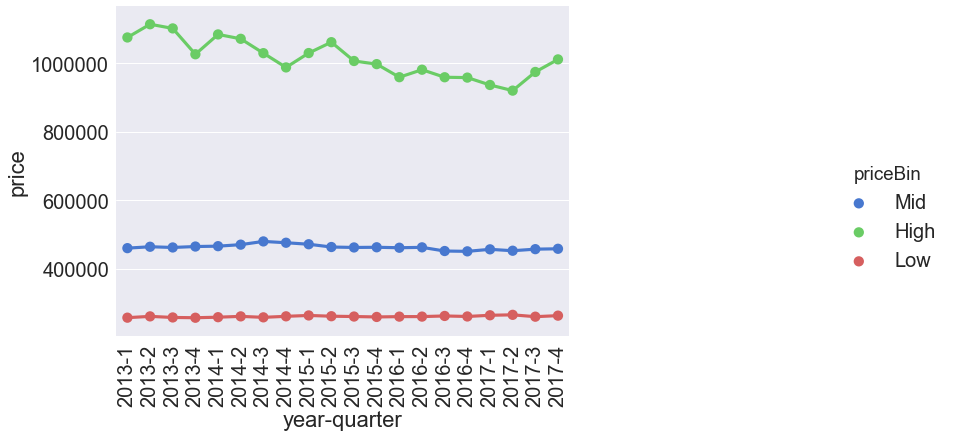

In [12]:
sns.set(font_scale = 2)
panda_list = []
for i in df_starKL['price_bins'].unique():
    df_temp = df_starKL[df_starKL['price_bins'] == i].groupby('year-quarter')['price'].mean().reset_index()
    df_temp['priceBin'] = i
    panda_list.append(df_temp)
df_total = pd.concat(panda_list)
plt.figure(figsize = (20,10))
g = sns.factorplot(x = 'year-quarter', y = 'price', hue = 'priceBin', data = df_total,
                 capsize=.2, palette="muted", size=6, aspect=.75)
g.fig.set_size_inches(20,6)
plt.xticks(rotation = '90')
df_total.to_excel('../data/excel/StarKL_pricebin_pricetrend.xlsx')

In [ ]:
sns.set(font_scale = 2)
for i in df_starKL['price_bins'].unique():
    plt.figure(figsize = (20,10))
    plt.plot(df_starKL[df_starKL['price_bins'] == i].groupby('year-quarter')['price'].mean(),label = i)
    plt.legend()

In [43]:
for i in df_napicKL['price_bins'].unique():
    df_starKL[df_starKL['price_bins'] == i].groupby('year-quarter')['price'].mean().reset_index()\
    .rename(columns = {'price':'Star'}).merge(df_napicKL_SecondMarket\
    [df_napicKL_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean().reset_index()\
    .rename(columns = {'HARGA_B':'NAPIC'}), on = 'year-quarter')\
    .to_excel('../data/excel/Comparison_{}pricebins_KualaLumpur.xlsx'.format(i),index = False)

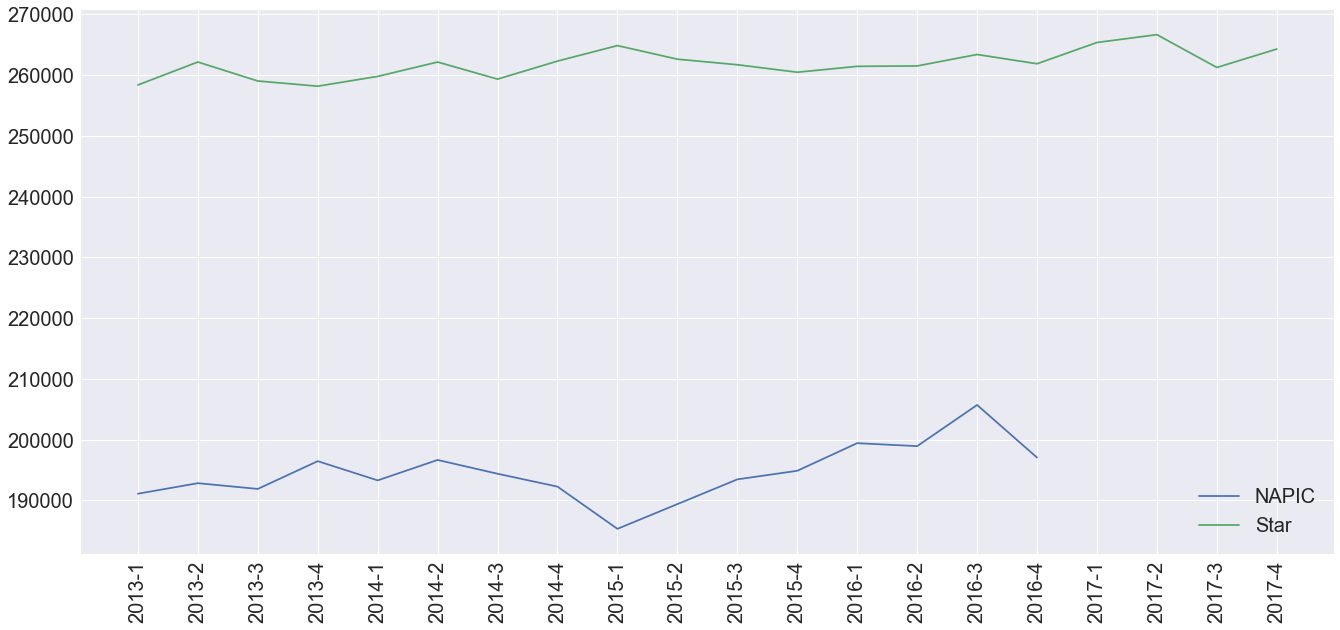

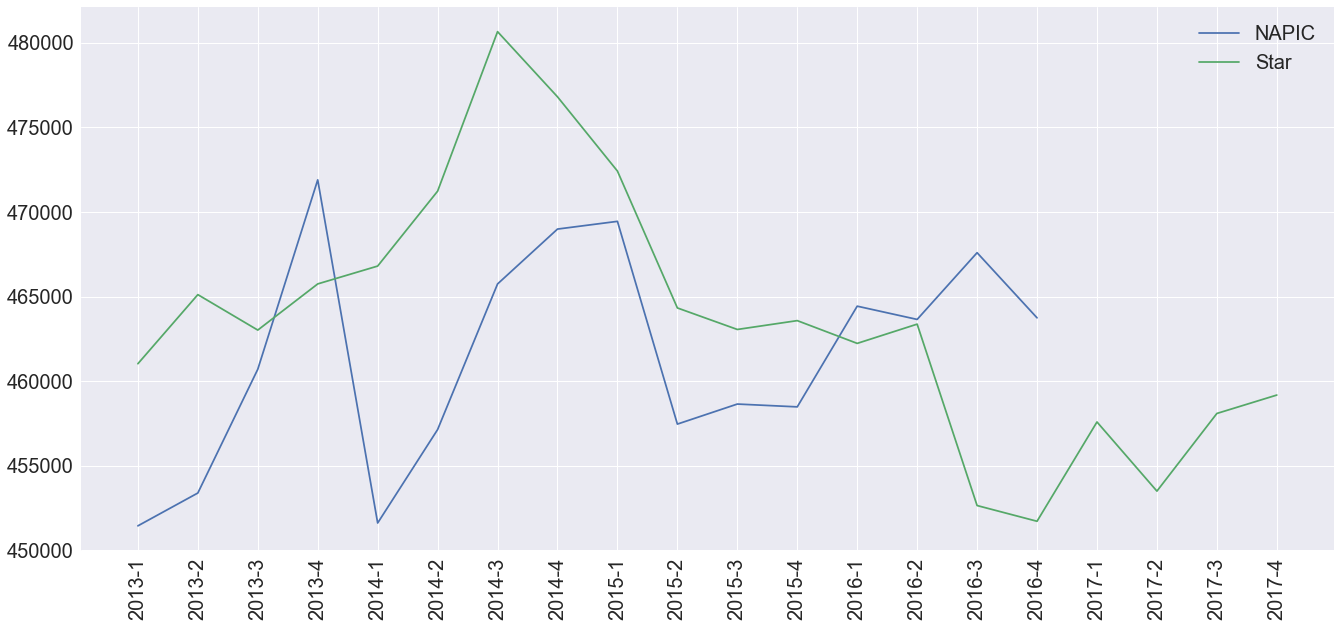

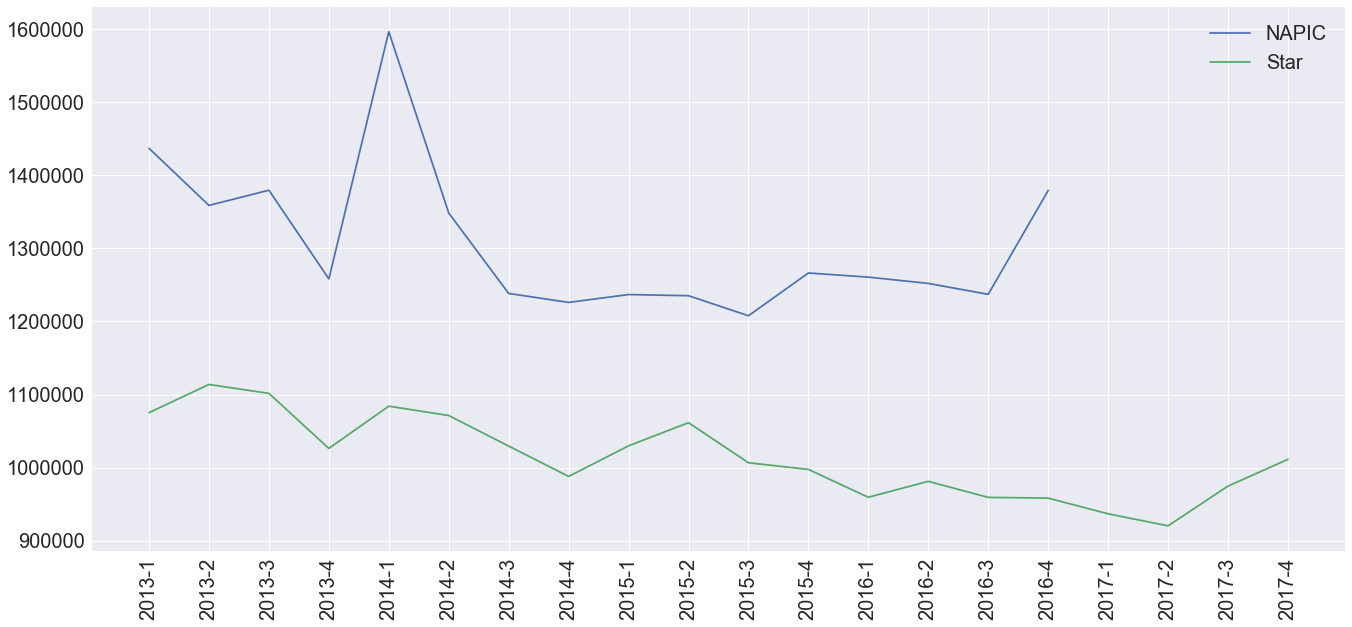

In [26]:
sns.set(font_scale = 2)
for i in df_napicKL['price_bins'].unique():
    plt.figure(figsize = (20,10))
    plt.plot(df_napicKL_SecondMarket
             [df_napicKL_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean(),label = 'NAPIC')
    plt.plot(df_starKL[df_starKL['price_bins'] == i].groupby('year-quarter')['price'].mean(),label = 'Star')
    plt.legend()
    plt.xticks(rotation = '90')
    plt.title('Condo Kuala Lumpur - {} price bins'.format(i))

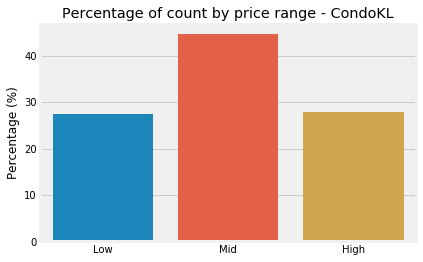

In [10]:
df_temp = df_napicKL_SecondMarket.groupby('price_bins').count().apply(lambda x:(x/x.sum())*100)['HARGA_B'].reset_index()

sorterIndex = dict(zip(['Low','Mid','High'],
                       range(len(['Low','Mid','High']))))
df_temp['pricebins_Rank'] = df_temp['price_bins'].map(sorterIndex)

plt = sns.barplot(['Low','Mid','High'],df_temp.sort_values('pricebins_Rank')['HARGA_B'].values)
plt.set_title('Percentage of count by price range - CondoKL')
plt.set_ylabel('Percentage (%)')
fig = plt.get_figure()
fig.savefig('../graphs/PercentageNAPICKL_byPriceRange.png', bbox_inches = 'tight')
df_temp.to_excel('../data/excel/NAPICKL_PriceRange.xlsx')

In [28]:
df_starKL.groupby('price_bins').count().apply(lambda x:x/x.sum())['price']

price_bins
High   0.259
Low    0.112
Mid    0.629
Name: price, dtype: float64

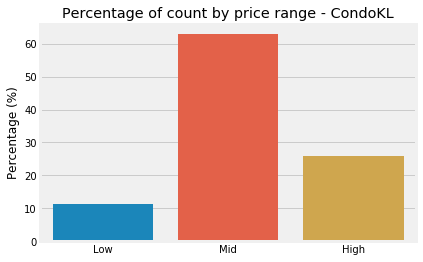

In [29]:
df_temp = df_starKL.groupby('price_bins').count().apply(lambda x:(x/x.sum())*100)['price'].reset_index()

sorterIndex = dict(zip(['Low','Mid','High'],
                       range(len(['Low','Mid','High']))))
df_temp['pricebins_Rank'] = df_temp['price_bins'].map(sorterIndex)

plt = sns.barplot(['Low','Mid','High'],df_temp.sort_values('pricebins_Rank')['price'].values)
plt.set_title('Percentage of count by price range - CondoKL')
plt.set_ylabel('Percentage (%)')
fig = plt.get_figure()
fig.savefig('../graphs/PercentageStarKL_byPriceRange.png', bbox_inches = 'tight')
df_temp.to_excel('../data/excel/StarKL_PriceRange.xlsx')

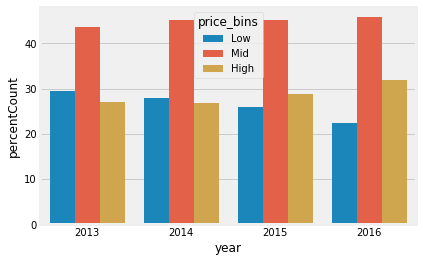

In [12]:
df_temp = df_napicKL_SecondMarket.groupby(['year','price_bins'])['HARGA_B'].count().reset_index()
df_temp['year'] = df_temp['year'].astype(int)
def getPercent(year_array,price_array):
    percent_array = []
    for i in enumerate(price_array):
        percent_array.append((i[1]/dict(df_temp.groupby('year')['HARGA_B'].sum())
                              [year_array[i[0]]])*100)
    return percent_array 
df_temp['percentCount'] = getPercent(df_temp['year'].values,df_temp['HARGA_B'].values)

sorterIndex = dict(zip(['Low','Mid','High'],
                       range(len(['Low','Mid','High']))))
df_temp['pricebins_Rank'] = df_temp['price_bins'].map(sorterIndex)
df_temp.pivot_table(columns = 'price_bins',values = 'percentCount',index = 'year')\
.to_excel('../data/excel/Pricebins_CondoKL_NAPIC.xlsx')
sns.barplot(x = 'year',y = 'percentCount',hue = 'price_bins',data = df_temp.sort_values(['year','pricebins_Rank']))


In [13]:
df_temp

year price_bins  HARGA_B  percentCount  pricebins_Rank
0   2013       High     2522        26.921               2
1   2013        Low     2770        29.569               0
2   2013        Mid     4076        43.510               1
3   2014       High     1893        26.802               2
4   2014        Low     1975        27.963               0
5   2014        Mid     3195        45.236               1
6   2015       High     1569        28.826               2
7   2015        Low     1417        26.033               0
8   2015        Mid     2457        45.141               1
9   2016       High     1038        31.929               2
10  2016        Low      725        22.301               0
11  2016        Mid     1488        45.771               1

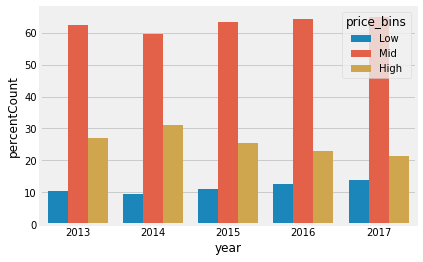

In [14]:
df_temp = df_starKL.groupby(['year','price_bins'])['price'].count().reset_index()
df_temp['year'] = df_temp['year'].astype(int)
def getPercent(year_array,price_array):
    percent_array = []
    for i in enumerate(price_array):
        percent_array.append((i[1]/dict(df_temp.groupby('year')['price'].sum())
                              [year_array[i[0]]])*100)
    return percent_array 
df_temp['percentCount'] = getPercent(df_temp['year'].values,df_temp['price'].values)

sorterIndex = dict(zip(['Low','Mid','High'],
                       range(len(['Low','Mid','High']))))
df_temp['pricebins_Rank'] = df_temp['price_bins'].map(sorterIndex)
df_temp.pivot_table(columns = 'price_bins',values = 'percentCount',index = 'year')\
.to_excel('../data/excel/Pricebins_CondoKL_star.xlsx')
sns.barplot(x = 'year',y = 'percentCount',hue = 'price_bins',data = df_temp.sort_values(['year','pricebins_Rank']))

In [15]:
df_temp

year price_bins  price  percentCount  pricebins_Rank
0   2013       High   3849        27.176               2
1   2013        Low   1475        10.414               0
2   2013        Mid   8839        62.409               1
3   2014       High   5617        31.104               2
4   2014        Low   1698         9.403               0
5   2014        Mid  10744        59.494               1
6   2015       High   7455        25.518               2
7   2015        Low   3235        11.073               0
8   2015        Mid  18525        63.409               1
9   2016       High   5616        23.074               2
10  2016        Low   3042        12.498               0
11  2016        Mid  15681        64.427               1
12  2017       High   1586        21.254               2
13  2017        Low   1037        13.897               0
14  2017        Mid   4839        64.849               1

# CondoSelangor

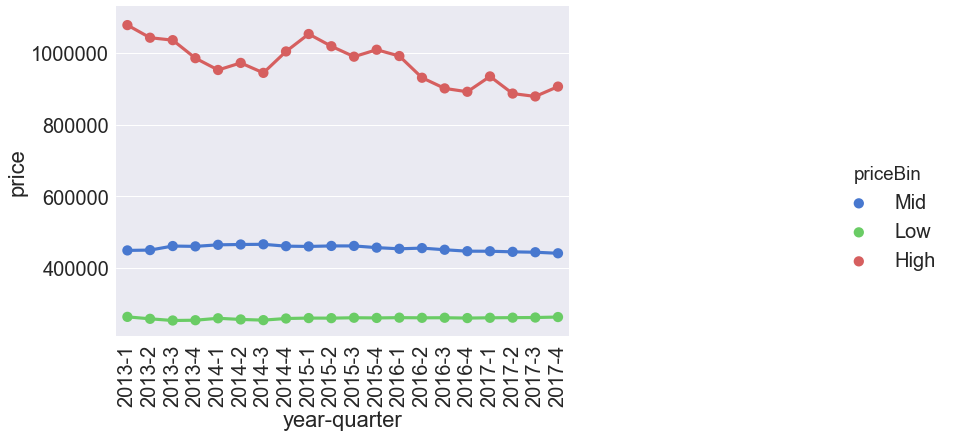

In [13]:
sns.set(font_scale = 2)
panda_list = []
for i in df_starSel['price_bins'].unique():
    df_temp = df_starSel[df_starSel['price_bins'] == i].groupby('year-quarter')['price'].mean().reset_index()
    df_temp['priceBin'] = i
    panda_list.append(df_temp)
df_total = pd.concat(panda_list)
plt.figure(figsize = (20,10))
g = sns.factorplot(x = 'year-quarter', y = 'price', hue = 'priceBin', data = df_total,
                 capsize=.2, palette="muted", size=6, aspect=.75)
g.fig.set_size_inches(20,6)
plt.xticks(rotation = '90')
df_total.to_excel('../data/excel/StarSel_pricebin_pricetrend.xlsx')

In [60]:
df_napicSel_SecondMarket.groupby('price_bins').count().apply(lambda x:x/x.sum())['HARGA_B']

price_bins
High   0.052
Low    0.657
Mid    0.291
Name: HARGA_B, dtype: float64

In [44]:
for i in df_napicSel['price_bins'].unique():
    df_starSel[df_starSel['price_bins'] == i].groupby('year-quarter')['price'].mean().reset_index()\
    .rename(columns = {'price':'Star'}).merge(df_napicSel_SecondMarket\
    [df_napicSel_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean().reset_index()\
    .rename(columns = {'HARGA_B':'NAPIC'}), on = 'year-quarter')\
    .to_excel('../data/excel/Comparison_{}pricebins_Selangor.xlsx'.format(i),index = False)

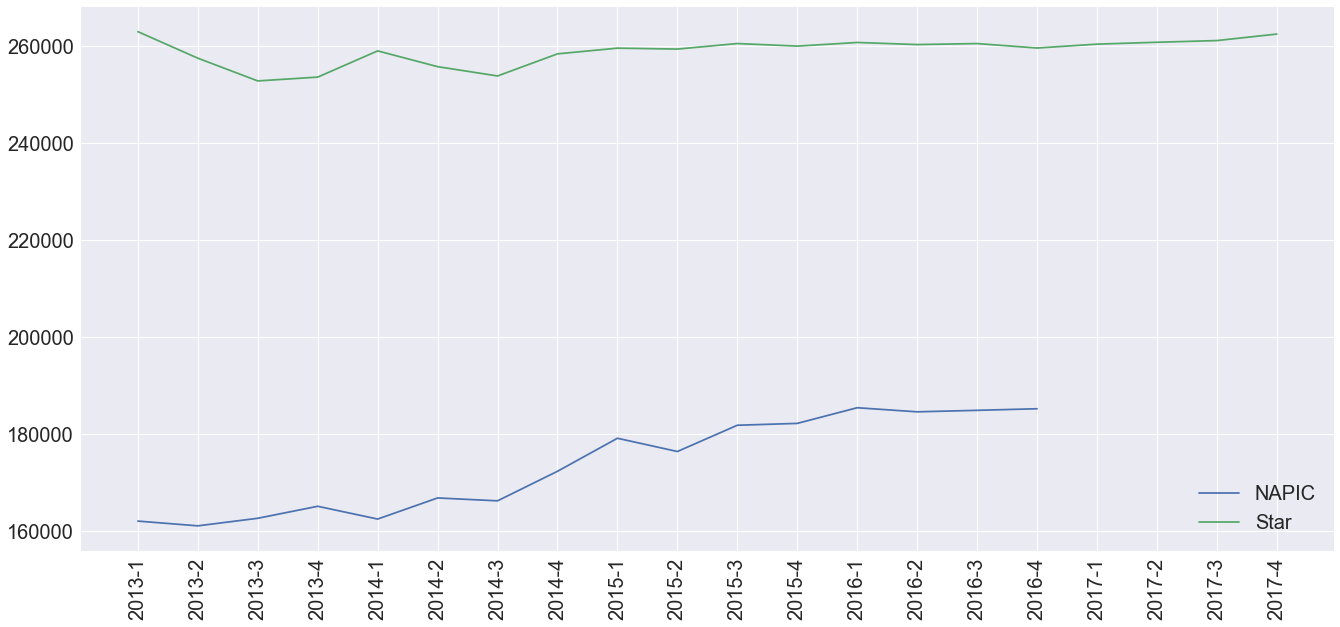

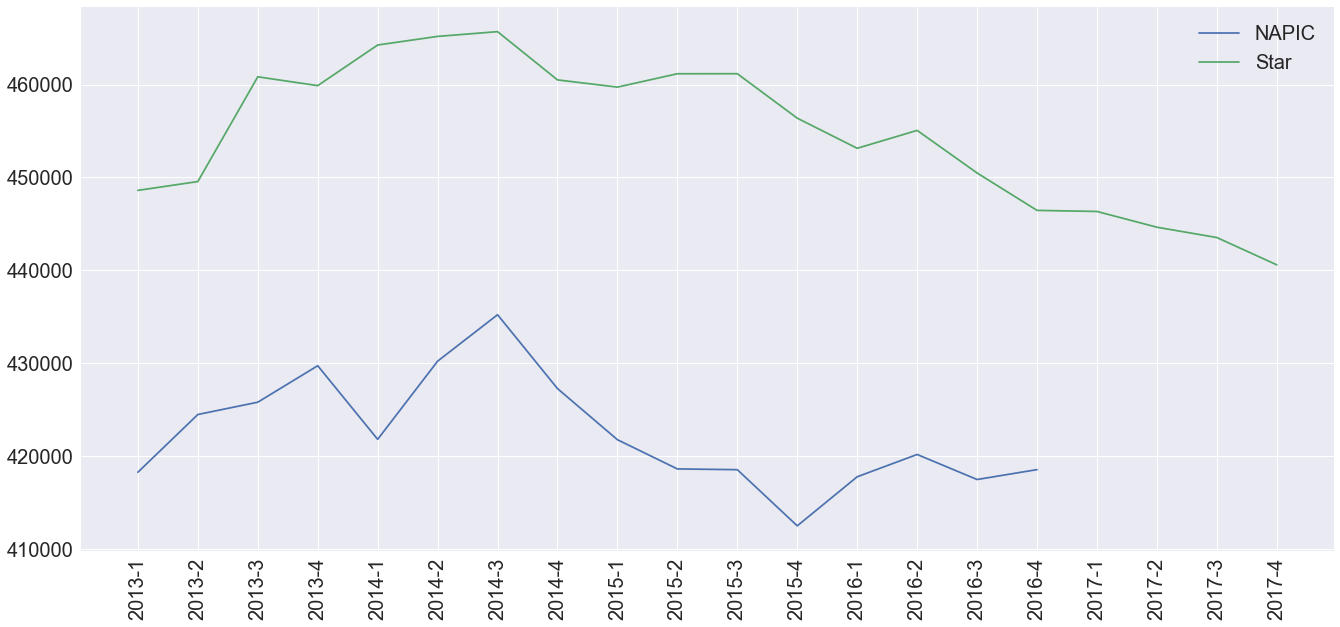

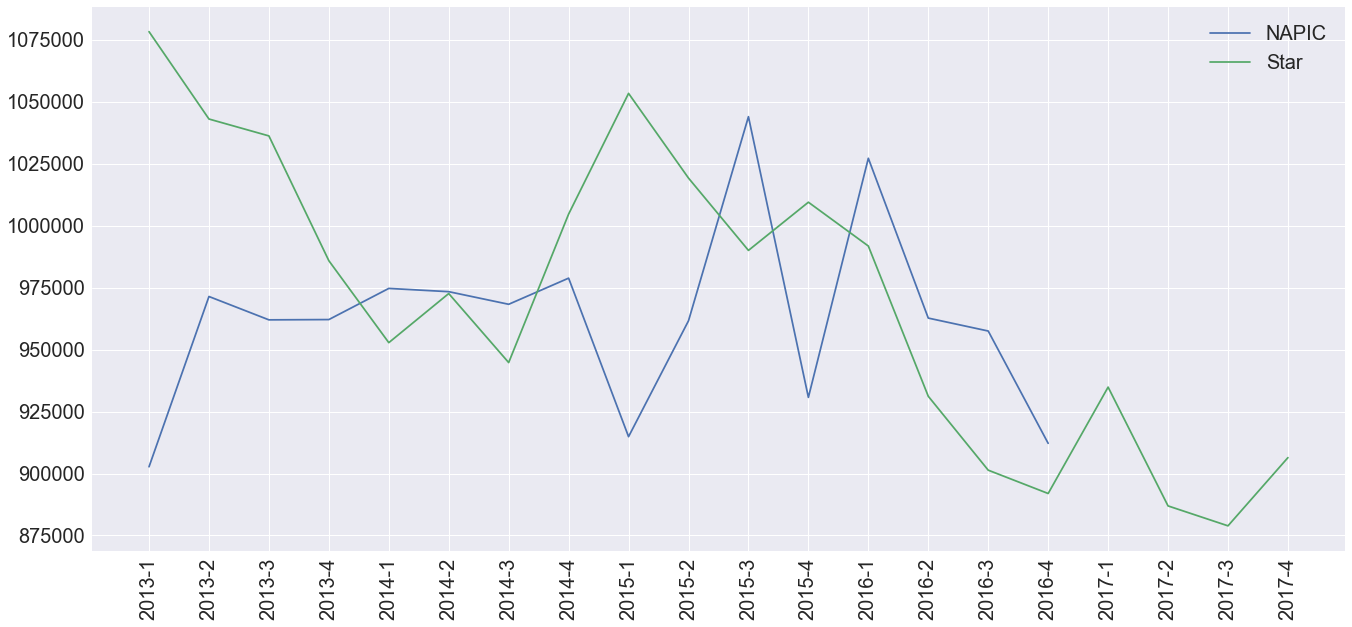

In [29]:
sns.set(font_scale = 2)
for i in df_napicSel['price_bins'].unique():
    plt.figure(figsize = (20,10))
    plt.plot(df_napicSel_SecondMarket
             [df_napicSel_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean(),label = 'NAPIC')
    plt.plot(df_starSel[df_starSel['price_bins'] == i].groupby('year-quarter')['price'].mean(),label = 'Star')
    plt.legend()
    plt.xticks(rotation = '90')
    plt.title('Condo Selangor - {} price bins'.format(i))

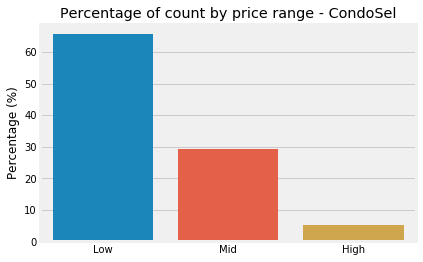

In [20]:
df_temp = df_napicSel_SecondMarket.groupby('price_bins').count().apply(lambda x:(x/x.sum())*100)['HARGA_B'].reset_index()

sorterIndex = dict(zip(['Low','Mid','High'],
                       range(len(['Low','Mid','High']))))
df_temp['pricebins_Rank'] = df_temp['price_bins'].map(sorterIndex)

plt = sns.barplot(['Low','Mid','High'],df_temp.sort_values('pricebins_Rank')['HARGA_B'].values)
plt.set_title('Percentage of count by price range - CondoSel')
plt.set_ylabel('Percentage (%)')
fig = plt.get_figure()
fig.savefig('../graphs/PercentageNAPICSel_byPriceRange.png', bbox_inches = 'tight')
df_temp.to_excel('../data/excel/NAPICSel_PriceRange.xlsx')

In [46]:
df_starSel.groupby('price_bins').count().apply(lambda x:x/x.sum())['price']

price_bins
High   0.210
Low    0.130
Mid    0.660
Name: price, dtype: float64

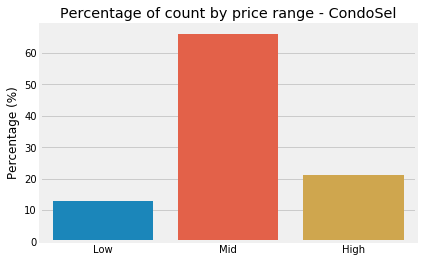

In [91]:
df_temp = df_starSel.groupby('price_bins').count().apply(lambda x:(x/x.sum())*100)['price'].reset_index()

sorterIndex = dict(zip(['Low','Mid','High'],
                       range(len(['Low','Mid','High']))))
df_temp['pricebins_Rank'] = df_temp['price_bins'].map(sorterIndex)

plt = sns.barplot(['Low','Mid','High'],df_temp.sort_values('pricebins_Rank')['price'].values)
plt.set_title('Percentage of count by price range - CondoSel')
plt.set_ylabel('Percentage (%)')
fig = plt.get_figure()
fig.savefig('../graphs/PercentageStarSel_byPriceRange.png', bbox_inches = 'tight')
df_temp.to_excel('../data/excel/StarSel_PriceRange.xlsx')

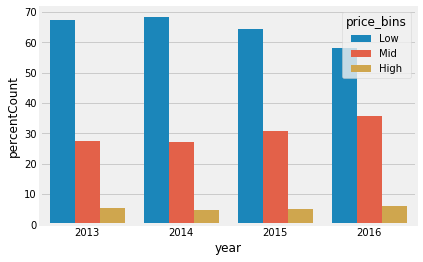

In [21]:
df_temp = df_napicSel_SecondMarket.groupby(['year','price_bins'])['HARGA_B'].count().reset_index()
df_temp['year'] = df_temp['year'].astype(int)
def getPercent(year_array,price_array):
    percent_array = []
    for i in enumerate(price_array):
        percent_array.append((i[1]/dict(df_temp.groupby('year')['HARGA_B'].sum())
                              [year_array[i[0]]])*100)
    return percent_array 
df_temp['percentCount'] = getPercent(df_temp['year'].values,df_temp['HARGA_B'].values)

sorterIndex = dict(zip(['Low','Mid','High'],
                       range(len(['Low','Mid','High']))))
df_temp['pricebins_Rank'] = df_temp['price_bins'].map(sorterIndex)
df_temp.pivot_table(columns = 'price_bins',values = 'percentCount',index = 'year')\
.to_excel('../data/excel/Pricebins_CondoSel_NAPIC.xlsx')
sns.barplot(x = 'year',y = 'percentCount',hue = 'price_bins',data = df_temp.sort_values(['year','pricebins_Rank']))


In [37]:
df_temp

year price_bins  HARGA_B  percentCount  pricebins_Rank
0   2013       High     1014         5.362               2
1   2013        Low    12722        67.273               0
2   2013        Mid     5175        27.365               1
3   2014       High      741         4.735               2
4   2014        Low    10685        68.270               0
5   2014        Mid     4225        26.995               1
6   2015       High      642         5.077               2
7   2015        Low     8125        64.250               0
8   2015        Mid     3879        30.674               1
9   2016       High      428         6.009               2
10  2016        Low     4142        58.150               0
11  2016        Mid     2553        35.842               1

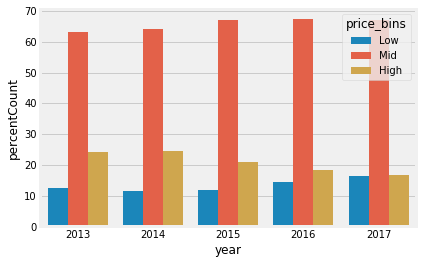

In [22]:
df_temp = df_starSel.groupby(['year','price_bins'])['price'].count().reset_index()
df_temp['year'] = df_temp['year'].astype(int)
def getPercent(year_array,price_array):
    percent_array = []
    for i in enumerate(price_array):
        percent_array.append((i[1]/dict(df_temp.groupby('year')['price'].sum())
                              [year_array[i[0]]])*100)
    return percent_array 
df_temp['percentCount'] = getPercent(df_temp['year'].values,df_temp['price'].values)

sorterIndex = dict(zip(['Low','Mid','High'],
                       range(len(['Low','Mid','High']))))
df_temp['pricebins_Rank'] = df_temp['price_bins'].map(sorterIndex)
df_temp.pivot_table(columns = 'price_bins',values = 'percentCount',index = 'year')\
.to_excel('../data/excel/Pricebins_CondoSel_Star.xlsx')
sns.barplot(x = 'year',y = 'percentCount',hue = 'price_bins',data = df_temp.sort_values(['year','pricebins_Rank']))


In [40]:
df_temp

year price_bins  price  percentCount  pricebins_Rank
0   2013       High   5137        24.295               2
1   2013        Low   2656        12.561               0
2   2013        Mid  13351        63.143               1
3   2014       High   7423        24.386               2
4   2014        Low   3514        11.544               0
5   2014        Mid  19503        64.070               1
6   2015       High   9459        20.995               2
7   2015        Low   5354        11.884               0
8   2015        Mid  30241        67.122               1
9   2016       High   7431        18.148               2
10  2016        Low   5949        14.529               0
11  2016        Mid  27567        67.324               1
12  2017       High   1984        16.632               2
13  2017        Low   1934        16.213               0
14  2017        Mid   8011        67.156               1

# Breakdown in district

In [5]:
district_dict = {'North':['Kepong','Batu','Wangsa Maju','Setiawangsa'],
                'Central':['Segambut','Bukit Bintang','Titiwangsa','Lembah Pantai'],
                'South':['Cheras','Bandar Tun Razak','Seputeh']}
df_starKL['district_type'] = df_starKL['district_master'].map(lambda x:''.join([i for i,j in district_dict.items() if x in j]))

df_starKL_district = df_starKL[df_starKL['district_type']!=''].copy()

weightage_NAPICKL = {'Central':43.1,'North':38.5, 'South':18.4}
weightage_NAPICSel = {'Petaling Jaya':72.5, 
                  'Ulu Langat':27.5}
#Create price bins for KL and Selangor
bins = [0, 300000, 650000]
priceRange_dict = {1:'Low',2:'Mid',3:'High'}

df_starKL_district['price_bins'] = list(map(lambda x:priceRange_dict[x],np.searchsorted(bins, 
                                                                                df_starKL_district['price'].values)))

#hulu langat = ulu langat, gombak = batu
#Create price bins for selangor

df_starSel_district = df_starSel[df_starSel['district_master'].isin(weightage_NAPICSel.keys())].copy()

df_starSel_district['price_bins'] = list(map(lambda x:priceRange_dict[x],np.searchsorted(bins, 
                                                                                df_starSel_district['price'].values)))

In [9]:
df_starKL_district.groupby('district_type')['Location_property'].count()

district_type
Central    61084
North      12671
South       7130
Name: Location_property, dtype: int64

In [6]:
df_starSel_district.groupby(['district_master'])['Location_property'].count()

district_master
Petaling Jaya    16633
Ulu Langat       27953
Name: Location_property, dtype: int64

In [5]:
region = ['Central','North','South']
priceRange = ['Low','Mid','High']
#all combination for breakdown by area and price bins
Combination_KL = list(itertools.product(region,priceRange))

district = ['Petaling Jaya','Ulu Langat']
priceRange = ['Low','Mid','High']
Combination_Sel = list(itertools.product(district,priceRange))

def crossCorr(leading,lagging):
    return sorted([(i,leading.corr(lagging.shift(-i))) for i in range(1,5)],
       key = lambda x:x[1],reverse = True)[0]

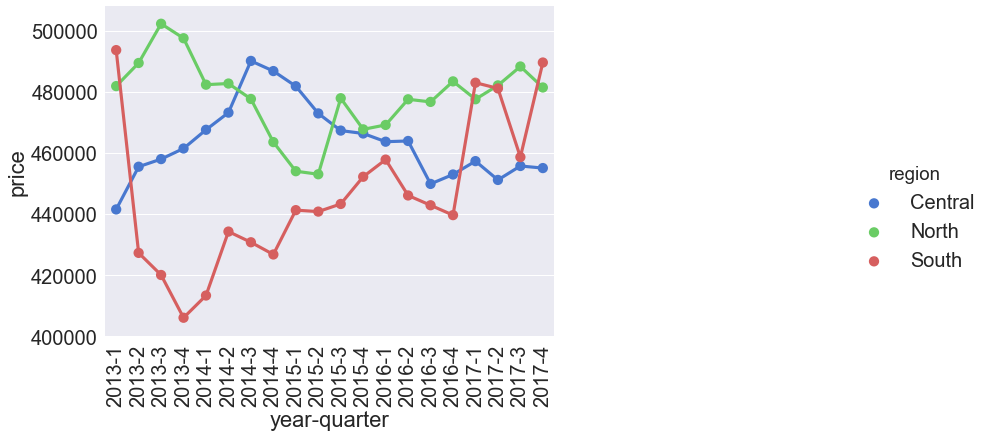

In [18]:
#plot mid price bin for all region - starKL condo
sns.set(font_scale = 2)
panda_list = []
for i in region:
    df_temp = df_starKL_district[(df_starKL_district['price_bins'] == 'Mid')&
                                (df_starKL_district['district_type'] == i)].groupby('year-quarter')['price'].mean().reset_index()
    df_temp['region'] = i
    panda_list.append(df_temp)
df_total = pd.concat(panda_list)
plt.figure(figsize = (20,10))
g = sns.factorplot(x = 'year-quarter', y = 'price', hue = 'region', data = df_total,
                 capsize=.2, palette="muted", size=6, aspect=.75)
g.fig.set_size_inches(20,6)
plt.xticks(rotation = '90')
df_total.to_excel('../data/excel/StarKL_Midpricebin_pricetrend.xlsx')    

In [10]:
df_starSel_district[(df_starSel_district['price_bins'] == 'Mid')].groupby('district_master')['Location_property'].count()

district_master
Petaling Jaya    11094
Ulu Langat       18688
Name: Location_property, dtype: int64

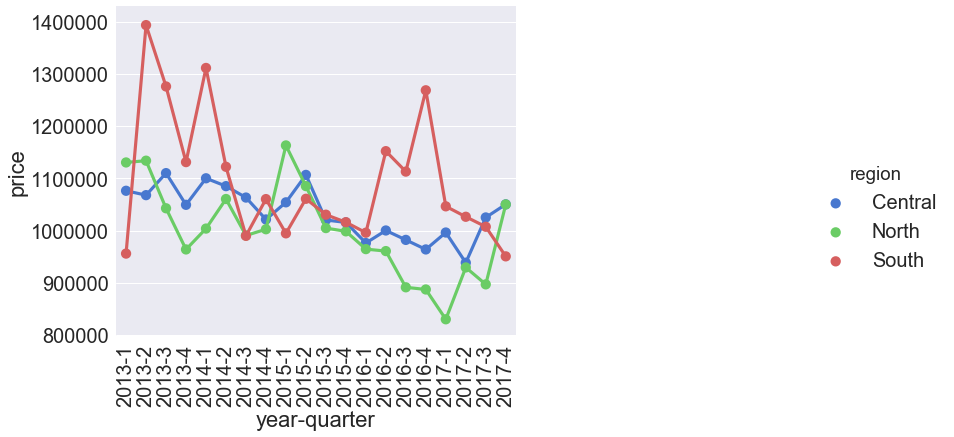

In [12]:
#plot high price bin for all region - starKL condo
sns.set(font_scale = 2)
panda_list = []
for i in region:
    df_temp = df_starKL_district[(df_starKL_district['price_bins'] == 'High')&
                                (df_starKL_district['district_type'] == i)].groupby('year-quarter')['price'].mean().reset_index()
    df_temp['region'] = i
    panda_list.append(df_temp)
df_total = pd.concat(panda_list)
plt.figure(figsize = (20,10))
g = sns.factorplot(x = 'year-quarter', y = 'price', hue = 'region', data = df_total,
                 capsize=.2, palette="muted", size=6, aspect=.75)
g.fig.set_size_inches(20,6)
plt.xticks(rotation = '90')
df_total.to_excel('../data/excel/StarKL_Highpricebin_pricetrend.xlsx')   

In [18]:
#til 2017-1
df_NAPIC_KLofficial = pd.read_excel('../data/external/Napic_averageKLPriceByDistrictTimeSeries.xlsx')
#til 2017-4
df_NAPIC_KLofficial2 = pd.read_excel('../data/external/NapicHighRise-PriceTimeSeries.xlsx')\
                        .rename(columns = {'Period':'year-quarter','Kuala Lumpur':'KL-averagePrice'})

df_NAPIC_KLofficialAll = df_NAPIC_KLofficial.merge(df_NAPIC_KLofficial2,how = 'outer',on = ['year-quarter'])
#update kl average price
df_NAPIC_KLofficialAll.iloc[28:,1] = df_NAPIC_KLofficialAll.iloc[28:,10]
df_NAPIC_KLofficialAll

year-quarter  KL-averagePrice  KL-growth  KL-Central-AvePrice  \
0        2010-1           225350     -2.400               257905   
1        2010-2           243799      8.200               279421   
2        2010-3           250158      2.600               285450   
3        2010-4           253829      1.500               290097   
4        2011-1           256397      1.000               301535   
5        2011-2           271321      5.800               316516   
6        2011-3           282840      4.200               321510   
7        2011-4           297069      5.000               337174   
8        2012-1           314978      6.000               360096   
9        2012-2           313477     -0.500               370974   
10       2012-3           319004      1.800               374637   
11       2012-4           341289      7.000               404547   
12       2013-1           352061      3.200               419116   
13       2013-2           362506      3.000               435847   
14       2013-3           374056      3.200               436833   
15       2013-4           373947      0.000               428367   
16       2014-1           379445      1.500               431509   
17       2014-2           390377      2.900               435127   
18       2014-3           405910      4.000               456627   
19       2014-4           408866      0.700               465571   
20       2015-1           415279      1.600               467720   
21       2015-2           421539      1.500               469305   
22       2015-3           433609      2.900               489201   
23       2015-4           438754      1.200               494133   
24       2016-1           447375      2.000               503943   
25       2016-2           461295      3.100               513628   
26       2016-3           472053      2.300               522379   
27       2016-4           478905      1.500               532632   
28       2017-1           481375      0.500               532563   

    KL-Central-growth  KL-North-AvePrice  KL-North-growth  KL-South-AvePrice  \
0              -8.100             224375            2.900             151108   
1               8.300             245311            9.300             157161   
2               2.200             254272            3.700             158837   
3               1.600             271260            6.700             156957   
4               3.900             236116          -13.000             171717   
5               5.000             269919           14.300             168358   
6               1.600             299686           11.000             179257   
7               4.900             309020            3.100             177882   
8               6.800             317168            2.600             204668   
9               3.000             300631           -5.200             205668   
10              1.000             316076            5.100             194782   
11              8.000             341430            8.000             192765   
12              3.600             345964            1.300             207715   
13              4.000             359159            3.800             197669   
14              0.200             370783            3.200             233814   
15             -1.900             379692            2.400             234390   
16              0.700             391245            3.000             232719   
17              0.800             412089            5.300             240013   
18              4.900             421028            2.200             255387   
19              2.000             418947           -0.500             254867   
20              0.500             428223            2.200             265271   
21              0.300             444202            3.700             262116   
22              4.200             448525            1.000             272083   
23              1.000             452787  

In [10]:
#groupby district and year-quarter
starKL_Bydistrict_quarter = df_starKL_district.groupby(['district_type','year-quarter'])['price'].mean().reset_index()\
                                                                            .values

tuple_Bydistrict_quarter = [(i[0],i[1],i[2]*(weightage_NAPICKL[i[0]]/100)) for i in starKL_Bydistrict_quarter]

#starPeriod_list = [i for i in df_starKL['year-quarter'].unique() if i not in ['2017-2','2017-3','2017-4']]

d = defaultdict(list)
for i in [i for i in tuple_Bydistrict_quarter]:
    d[i[1]].append(i[2])
sum_averageprice = [(i,sum(j)) for i,j in d.items()]

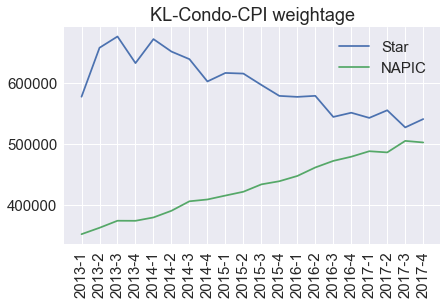

In [63]:
#KL by year-quarter
sns.set(font_scale = 1.5)
index = df_NAPIC_KLofficialAll.iloc[12:]['year-quarter'].values
Star_series = pd.Series([i[1] for i in sum_averageprice],name = 'Star',index = index)
NAPIC_series = pd.Series(df_NAPIC_KLofficialAll['KL-averagePrice_x'].iloc[12:].values,name = 'NAPIC',index = index)
plt.plot(Star_series,label = 'Star')
plt.plot(NAPIC_series,label = 'NAPIC')
plt.legend()
plt.title('KL-Condo-HPI weightage')
plt.savefig('KL-Condo-HPI weightage.png',bbox_inches = 'tight')
plt.xticks(rotation = '90')
Star_series.to_frame().merge(NAPIC_series.to_frame(),left_index = True, right_index = True)\
.to_excel('../data/excel/Comparison_KLCondo_HPIweightage.xlsx')

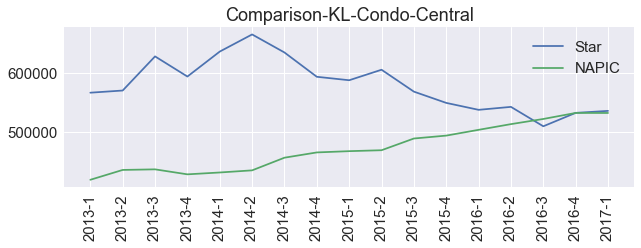

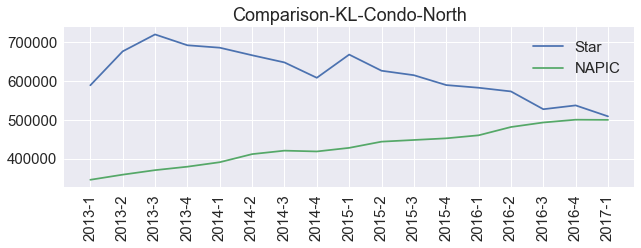

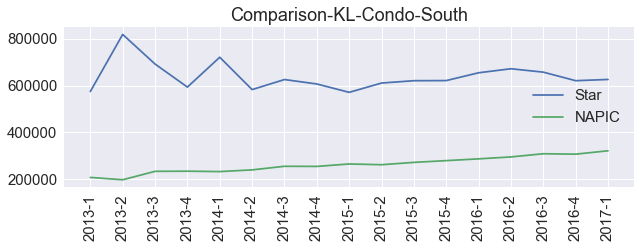

In [94]:
sns.set(font_scale = 1.5)
tuple_Bydistrict_quarter = [(i[0],i[1],i[2]) for i in starKL_Bydistrict_quarter]
for no,region in enumerate(['Central','North','South']):
    plt.figure(figsize = (20,10))
    plt.subplot(3,2,no+1)
    starPeriod_list = [i for i in df_starKL['year-quarter'].unique() if i not in ['2017-2','2017-3','2017-4']]
    Star = pd.Series([i[2] for i in [i for i in tuple_Bydistrict_quarter if i[1] in starPeriod_list] 
                        if i[0] == region], index = starPeriod_list)
    NAPIC = pd.Series(df_NAPIC_KLofficial['KL-{}-AvePrice'.format(region)].iloc[12:].values,
                         index = starPeriod_list)
    plt.plot(Star,label = 'Star')
    plt.plot(NAPIC,label = 'NAPIC')
    plt.legend()
    plt.xticks(rotation = '90')
    plt.title('Comparison-KL-Condo-{}'.format(region))
    plt.savefig('../graphs/Comparison-KL-Condo-{}.png'.format(region),bbox_inches = 'tight')
    Star.to_frame().merge(NAPIC.to_frame(),right_index = True, left_index = True)\
    .to_excel('../data/excel/Comparison-KL-Condo-{}.xlsx'.format(region))

In [64]:
#groupby district and year-quarter
starKL_Bydistrict_quarter_priceBins = df_starKL_district.groupby(['district_type','price_bins','year-quarter'])\
                                                        ['price'].mean().reset_index()\
                                                                            .values

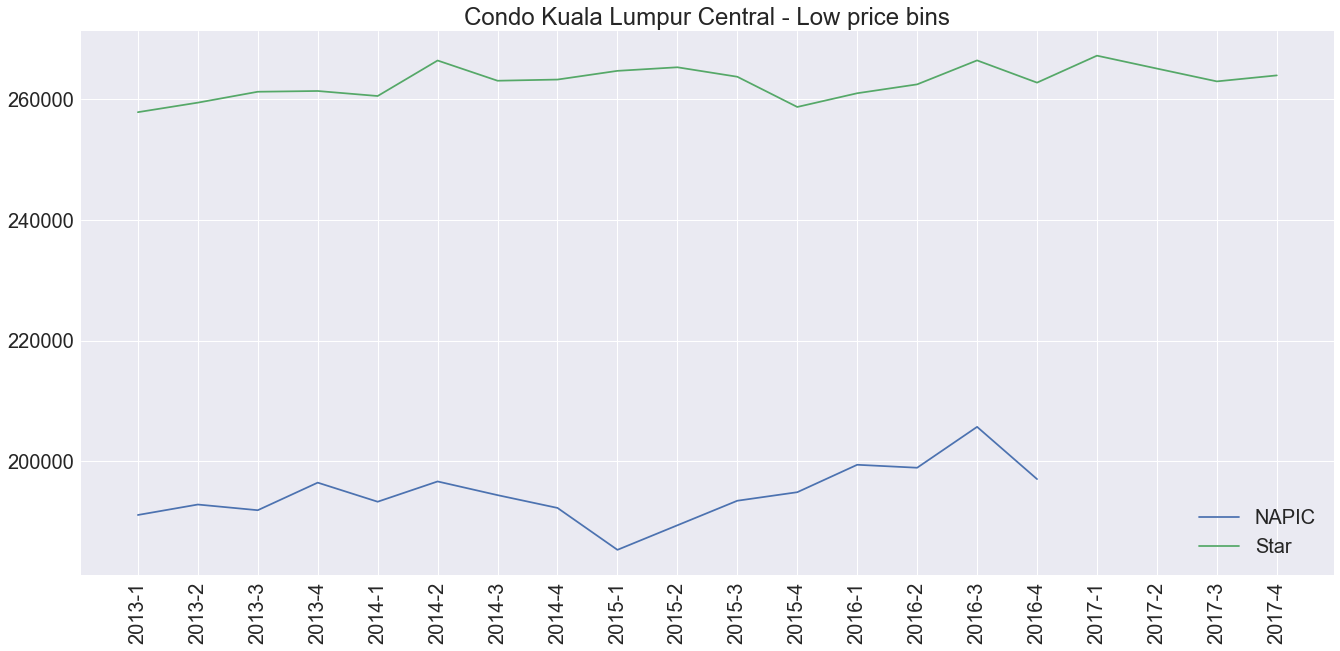

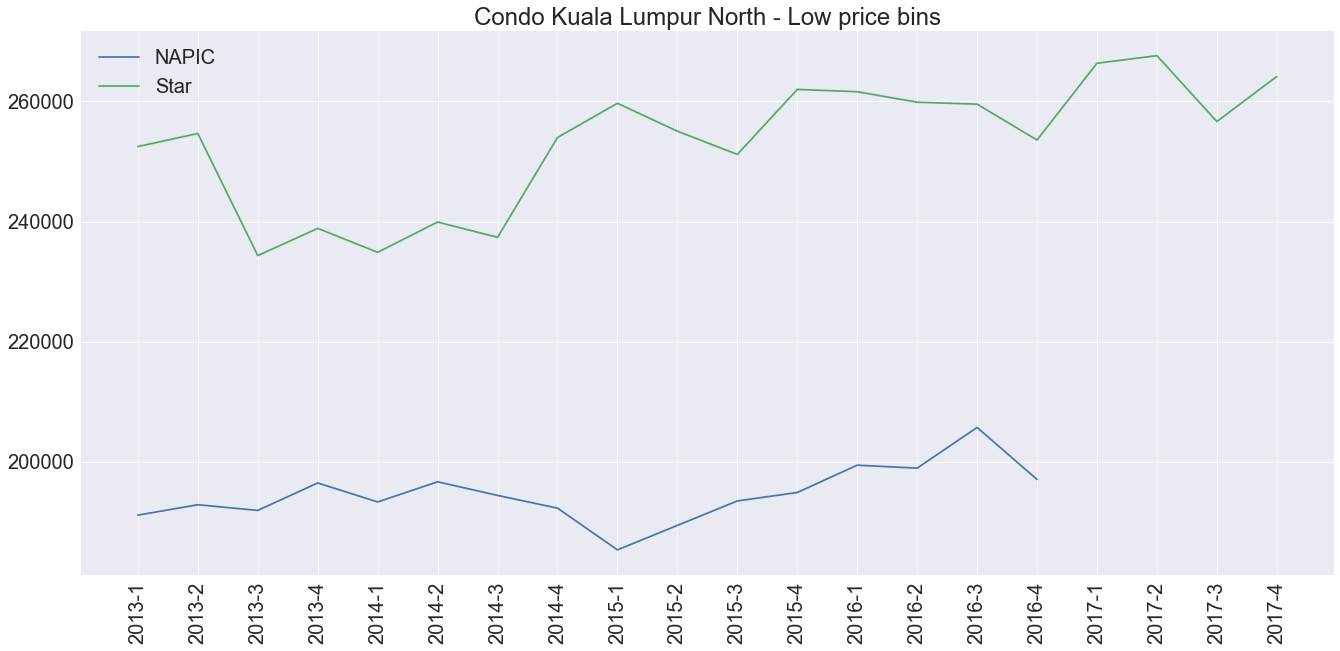

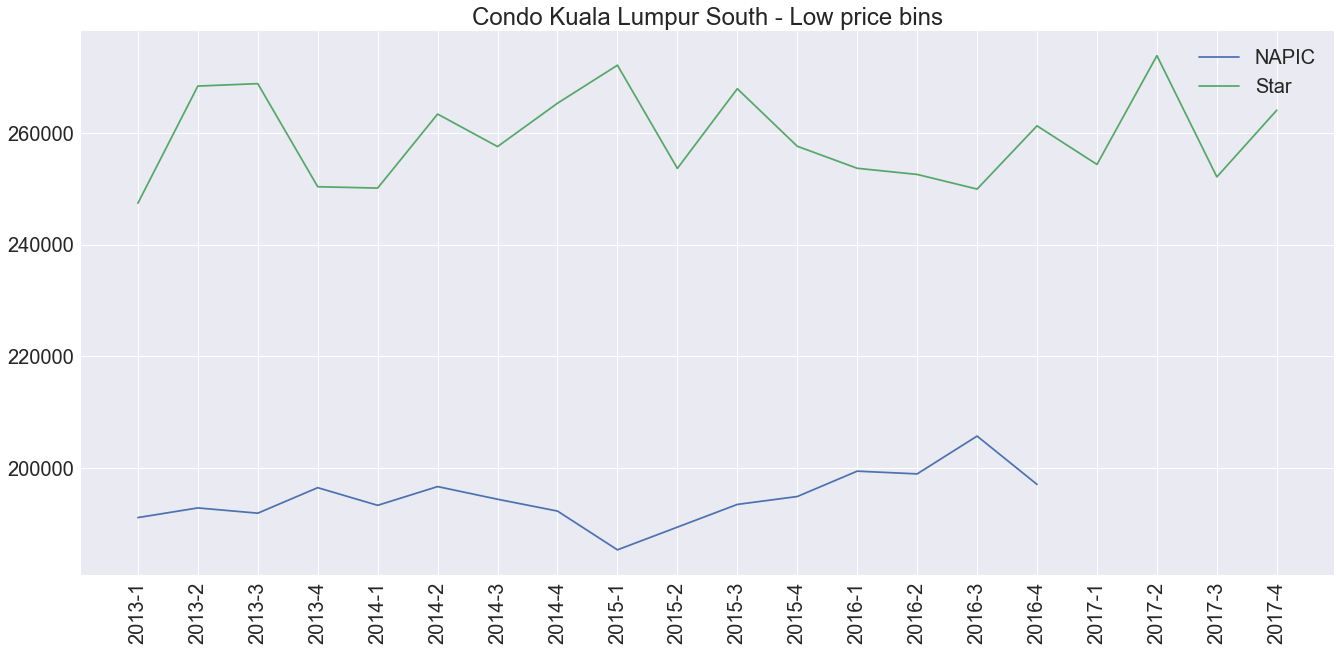

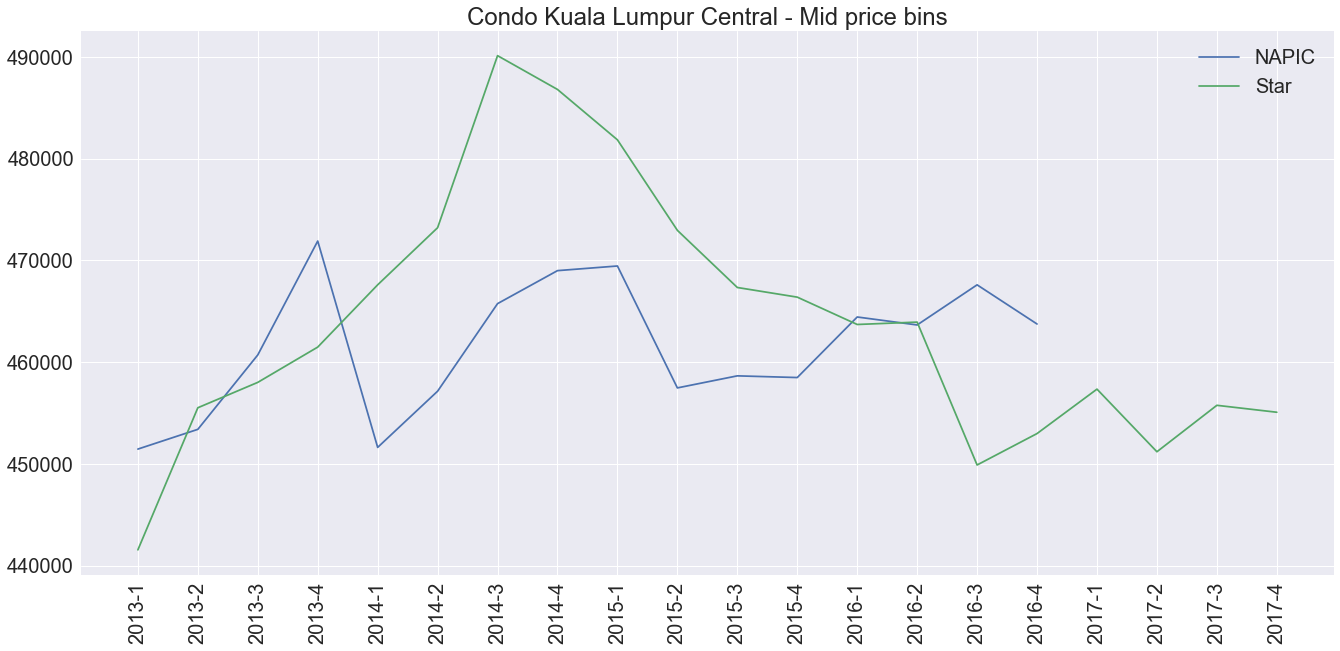

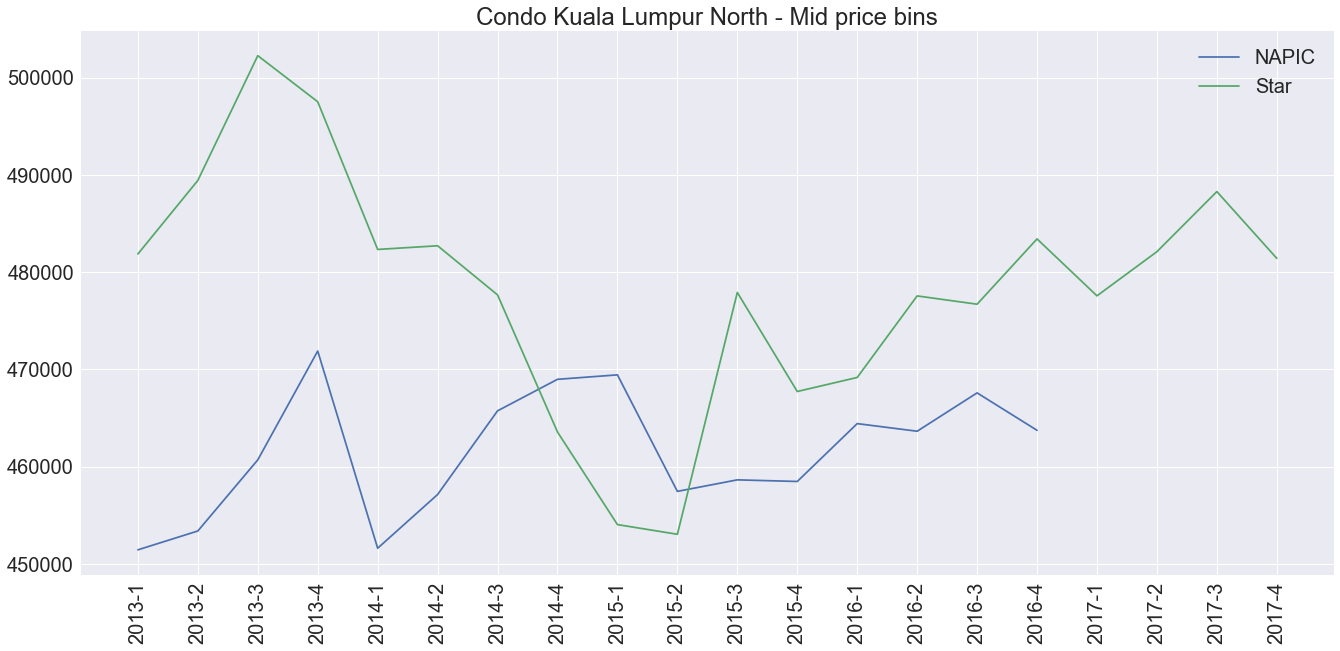

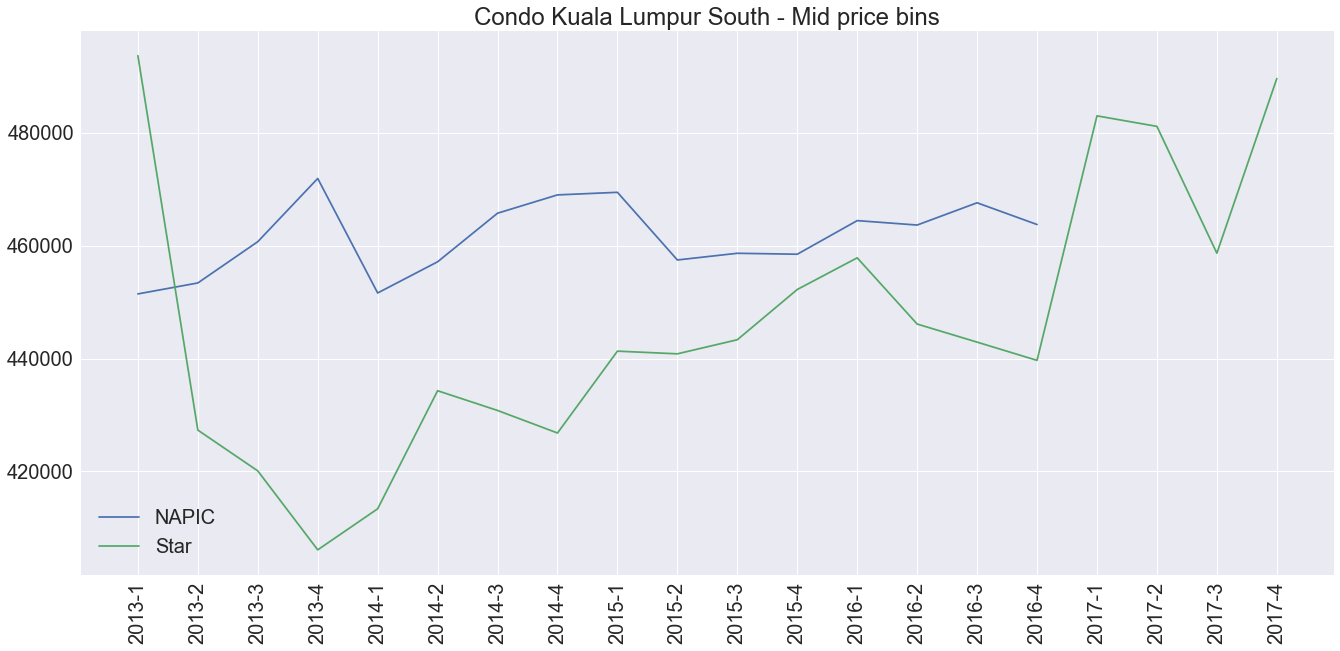

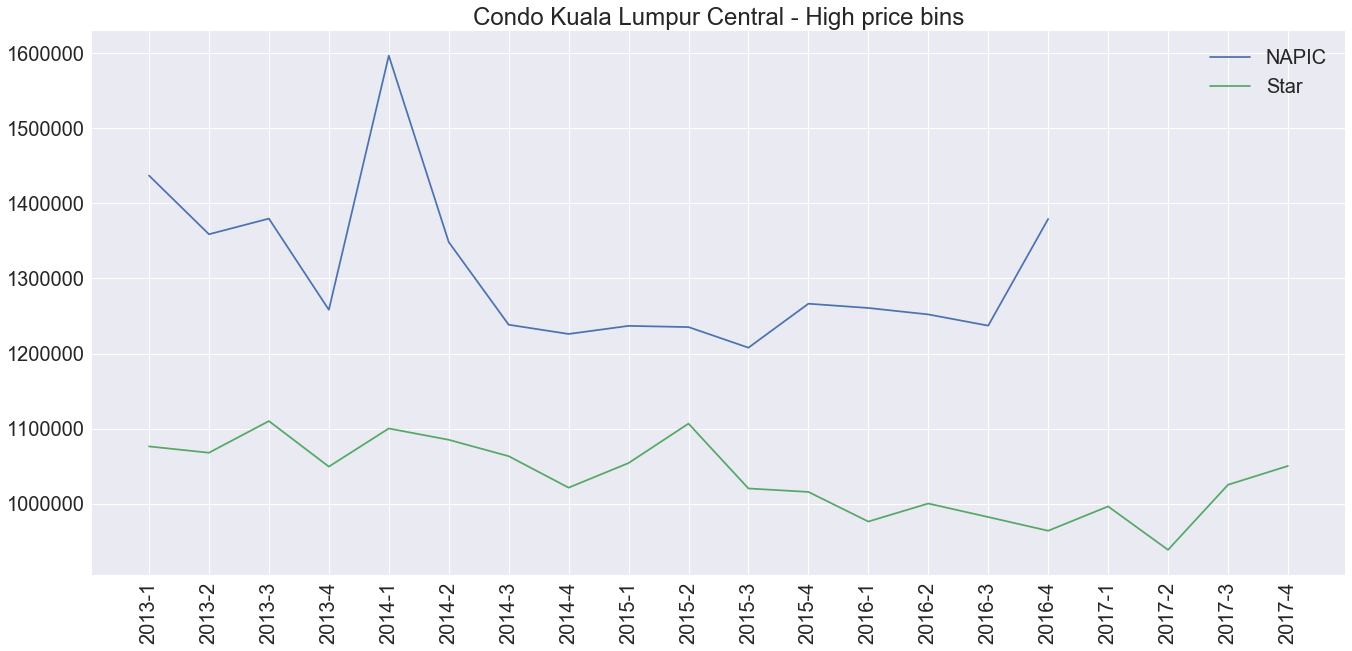

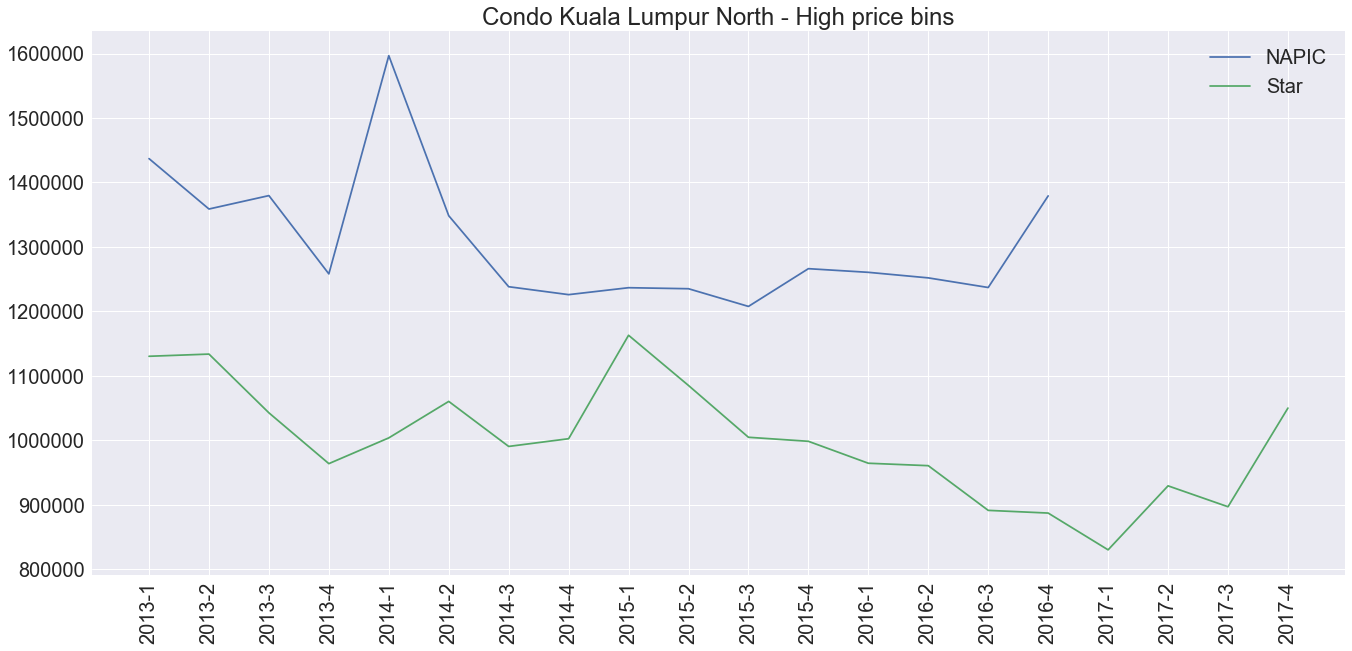

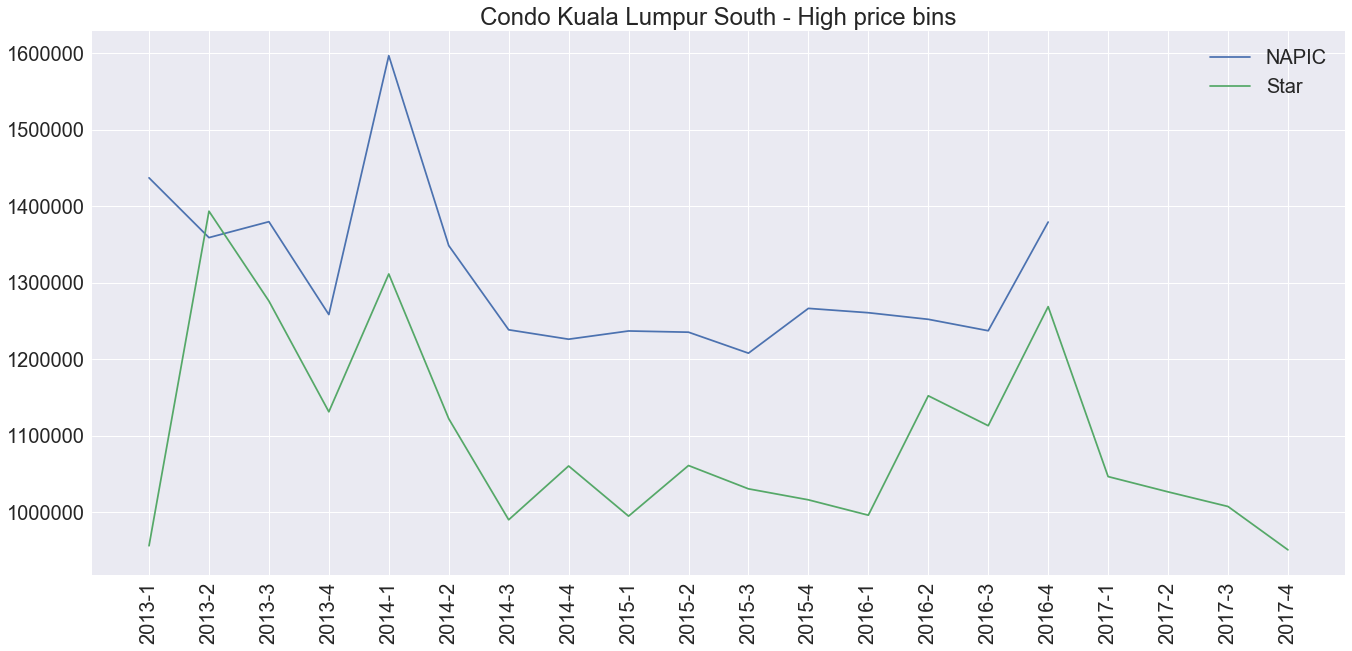

In [15]:
#Compare KL series by area by price bins
sns.set(font_scale = 2)
for i in df_napicKL['price_bins'].unique():
    for j in [i for i in Combination_KL if i[1] == 'Low']:
        plt.figure(figsize = (20,10))
        plt.plot(df_napicKL_SecondMarket
                 [df_napicKL_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean(),label = 'NAPIC')
        plt.plot(df_starKL_district[(df_starKL_district['price_bins'] == i)
                          & (df_starKL_district['district_type'] == j[0])]
                 .groupby('year-quarter')['price'].mean(),label = 'Star')
        plt.legend()
        plt.xticks(rotation = '90')
        plt.title('Condo Kuala Lumpur {} - {} price bins'.format(j[0],i))

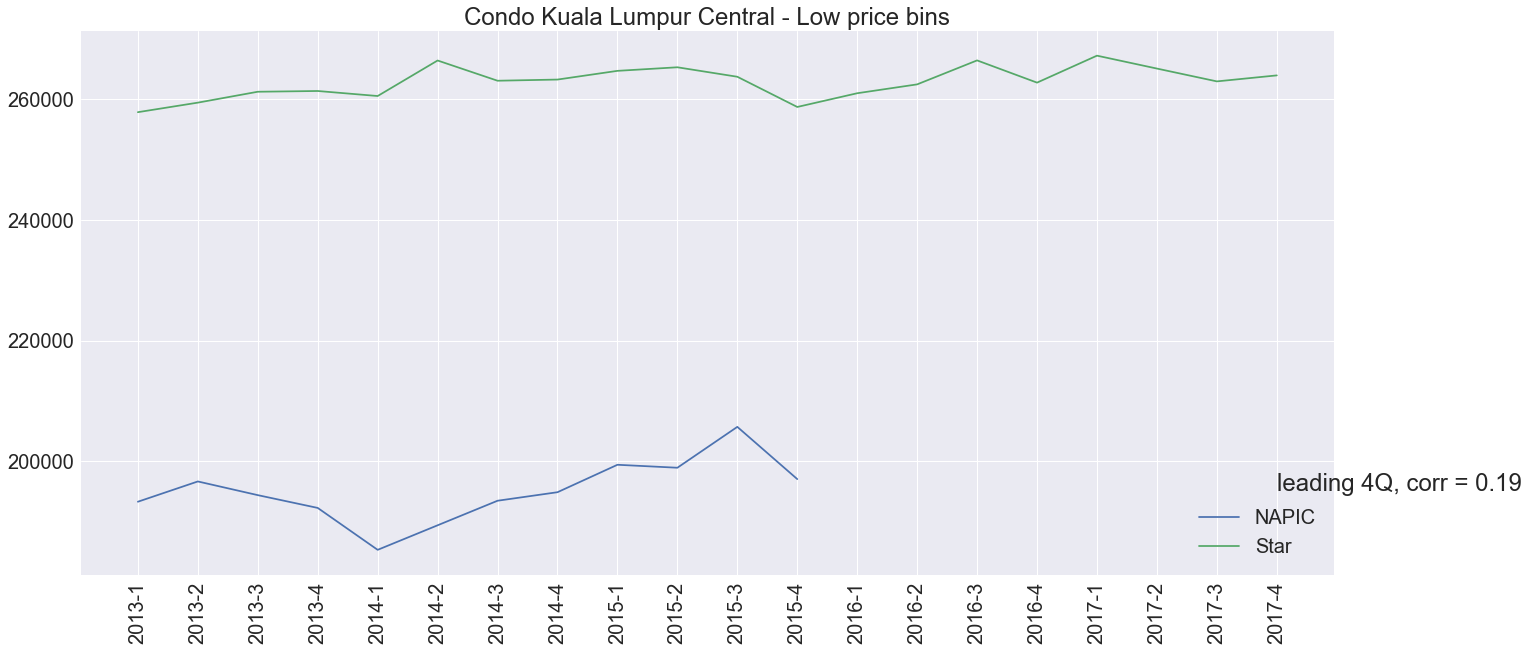

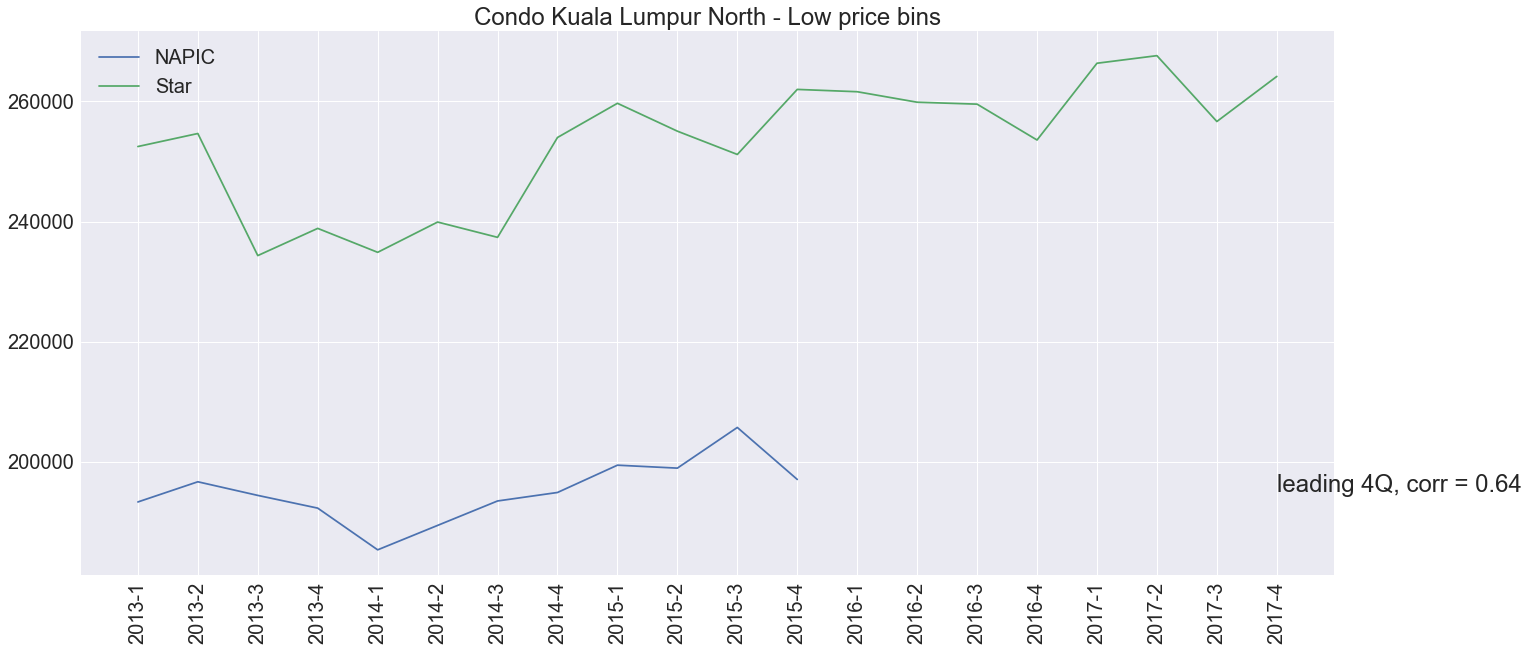

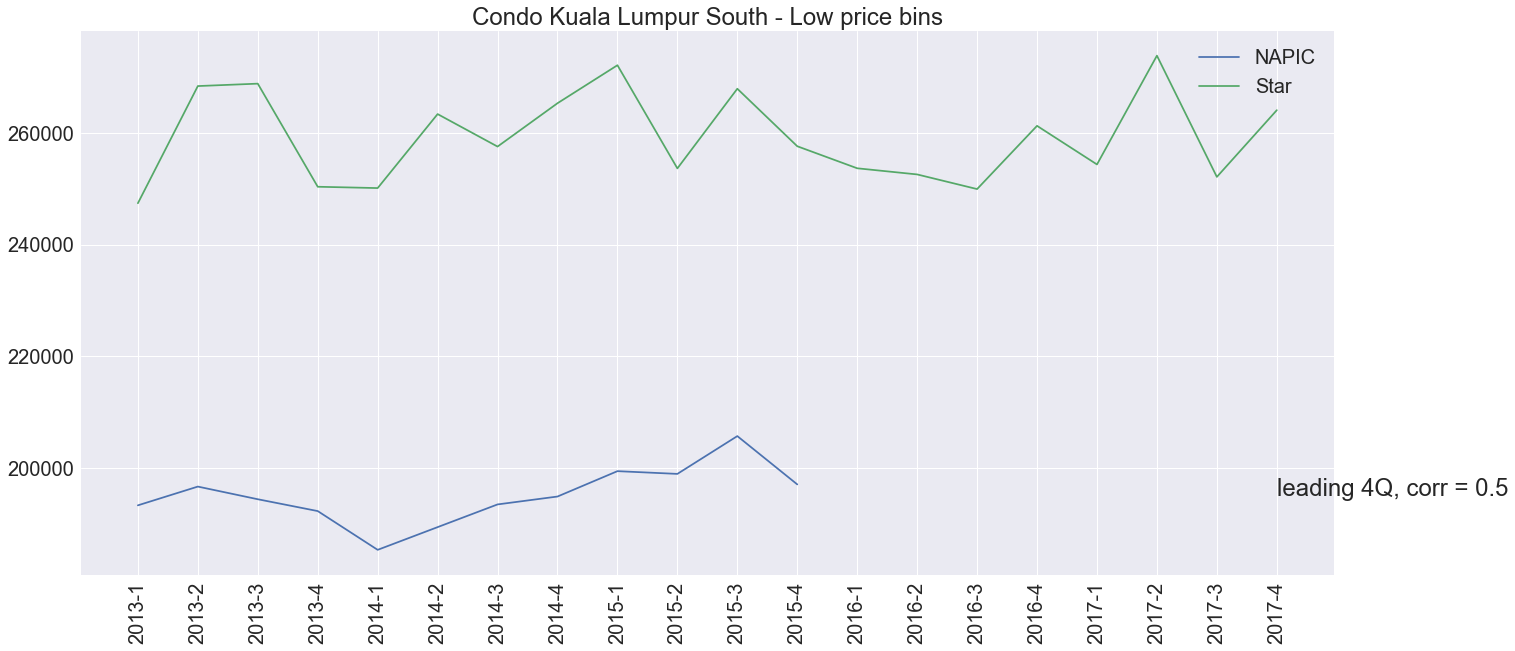

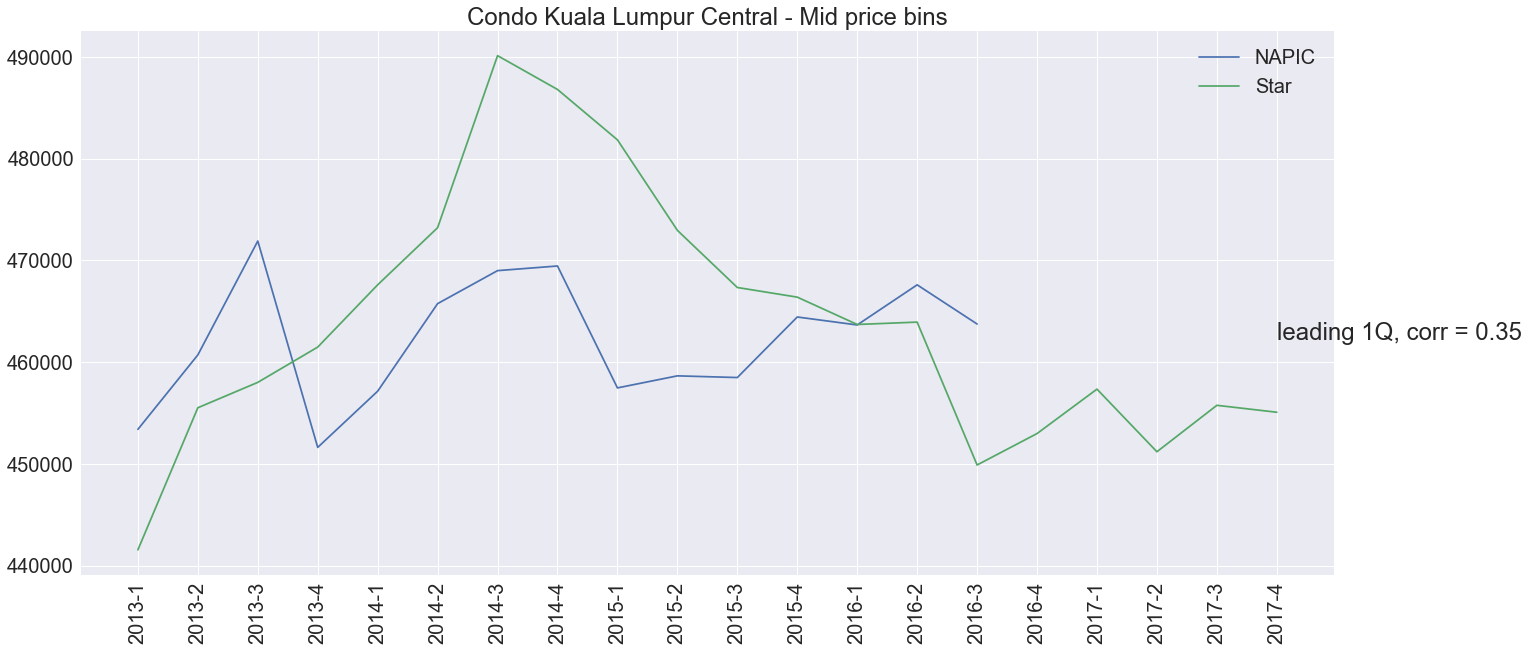

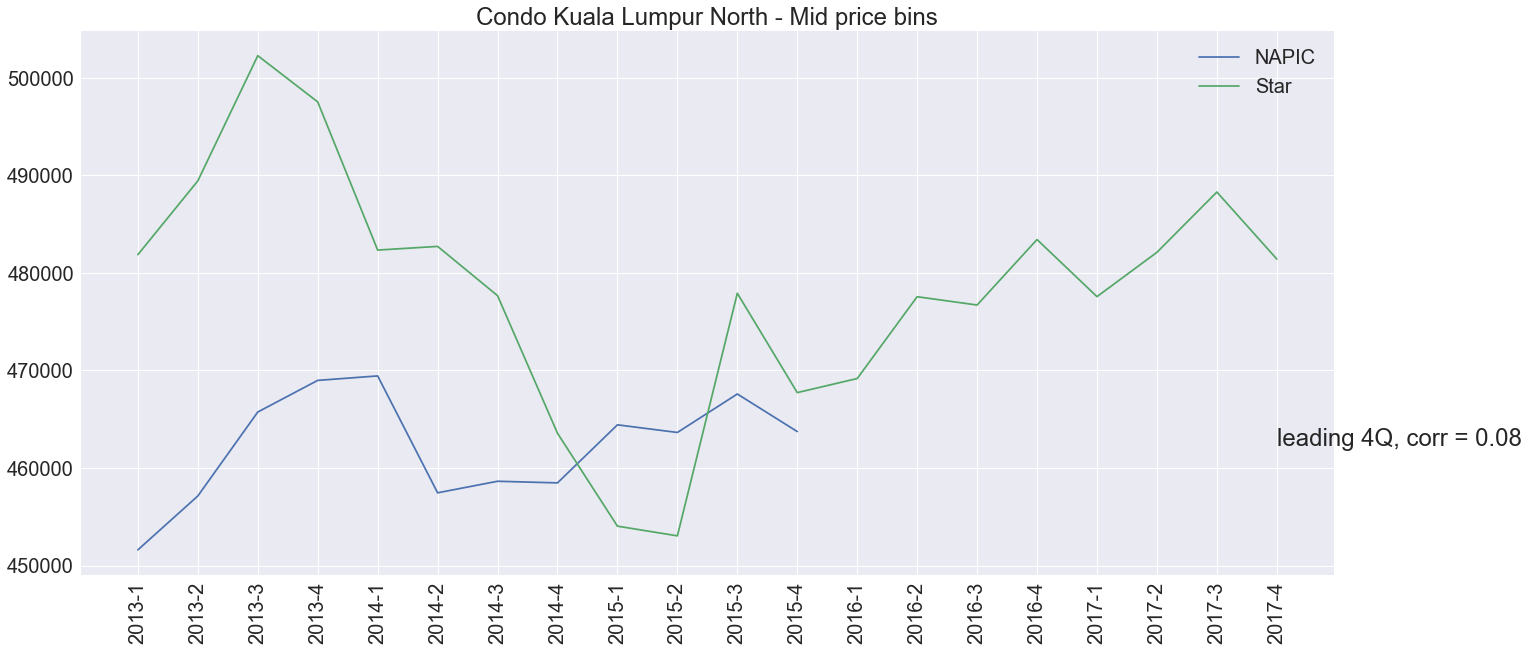

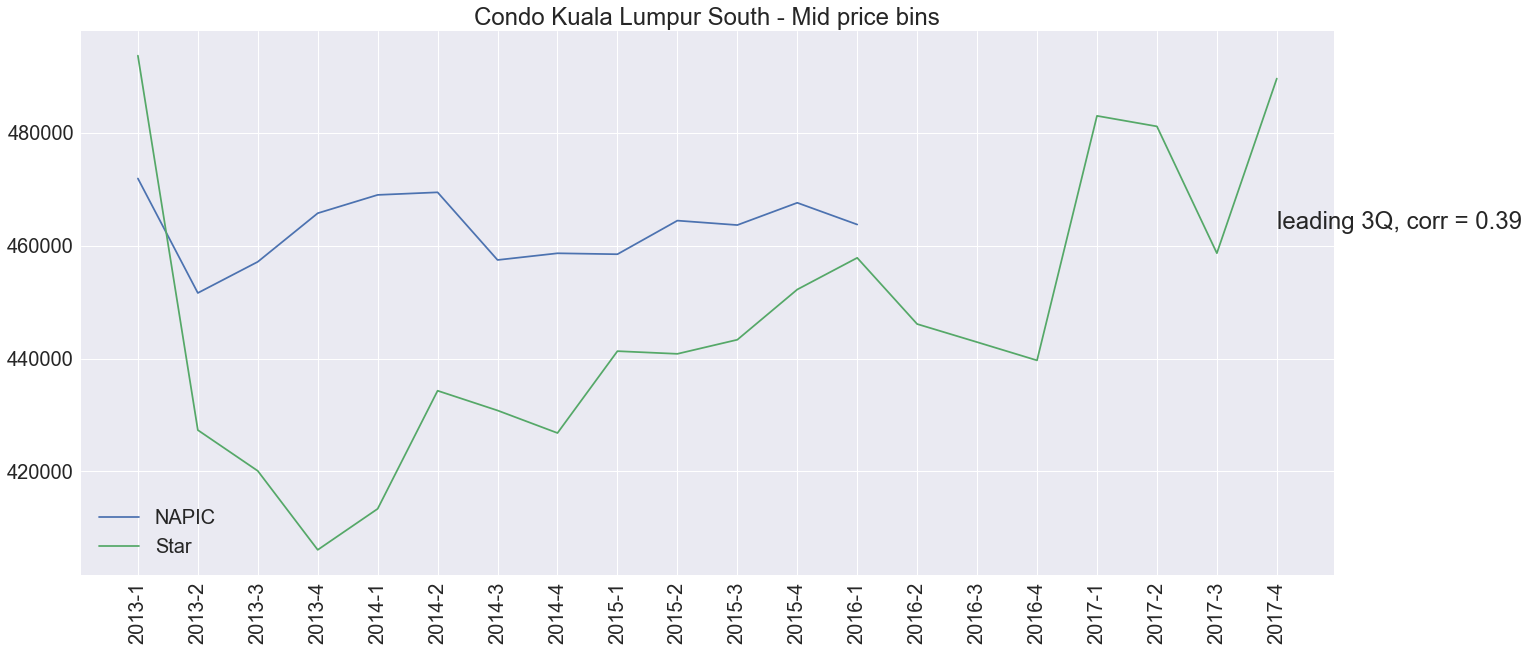

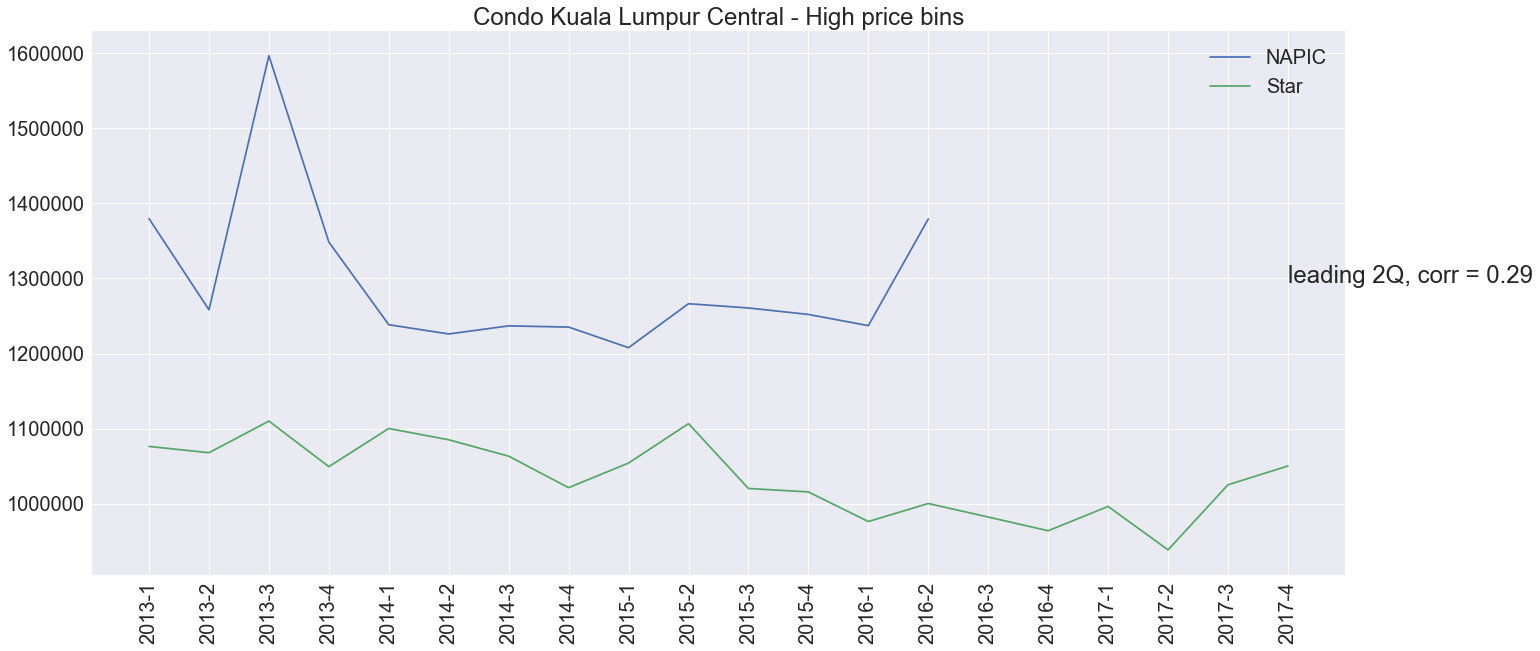

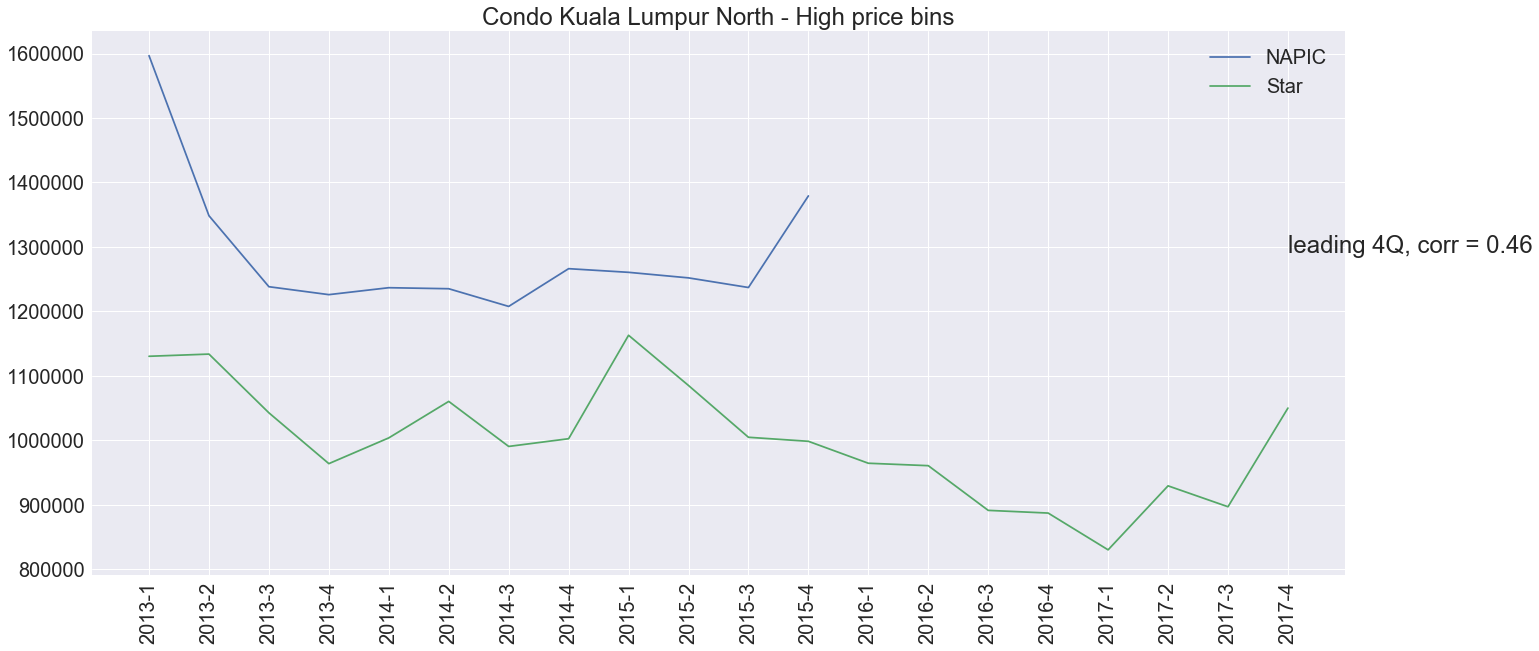

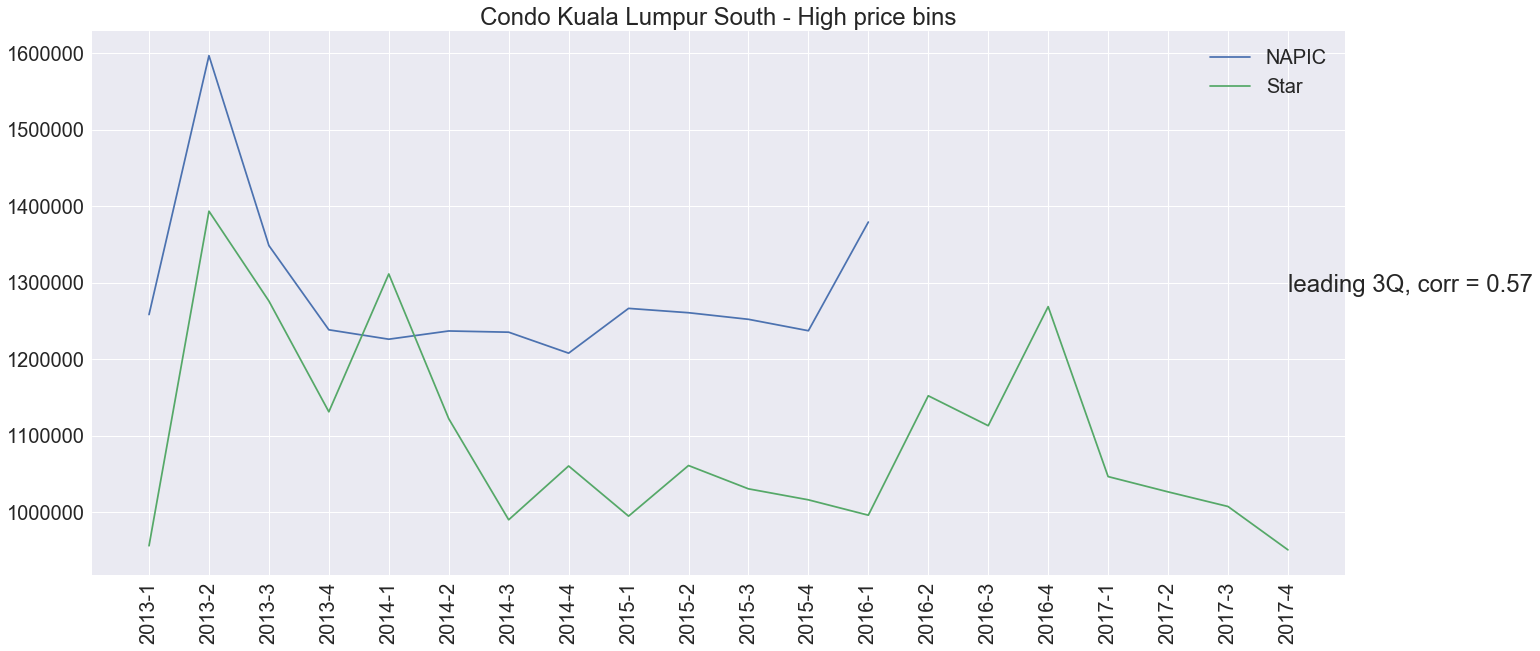

In [83]:
#Compare KL series by area by price bins
sns.set(font_scale = 2)
for i in df_napicKL['price_bins'].unique():
    for j in [i for i in Combination_KL if i[1] == 'Low']:
        plt.figure(figsize = (20,10))
        NAPIC = df_napicKL_SecondMarket\
        [df_napicKL_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean()
        Star = df_starKL_district[(df_starKL_district['price_bins'] == i)
                & (df_starKL_district['district_type'] == j[0])].groupby('year-quarter')['price'].mean()
        order,correlation = crossCorr(Star,NAPIC)
        plt.plot(NAPIC.shift(-order),label = 'NAPIC')
        plt.plot(Star,label = 'Star')
        plt.legend()
        plt.xticks(rotation = '90')
        plt.title('Condo Kuala Lumpur {} - {} price bins'.format(j[0],i))
        plt.text('2017-4',np.mean(df_napicKL_SecondMarket
                 [df_napicKL_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean()
                 .shift(-order).dropna()),'leading {}Q, corr = {}'.format(order,round(correlation,2)))
        plt.savefig('../graphs/Condo Kuala Lumpur {} - {} price bins.png'.format(j[0],i),
                   bbox_inches = 'tight')
        Star.to_frame().merge(NAPIC.shift(-order).to_frame(),left_index = True, right_index = True)\
        .to_excel('../data/excel/Condo Kuala Lumpur {} - {} price bins.xlsx'.format(j[0],i))

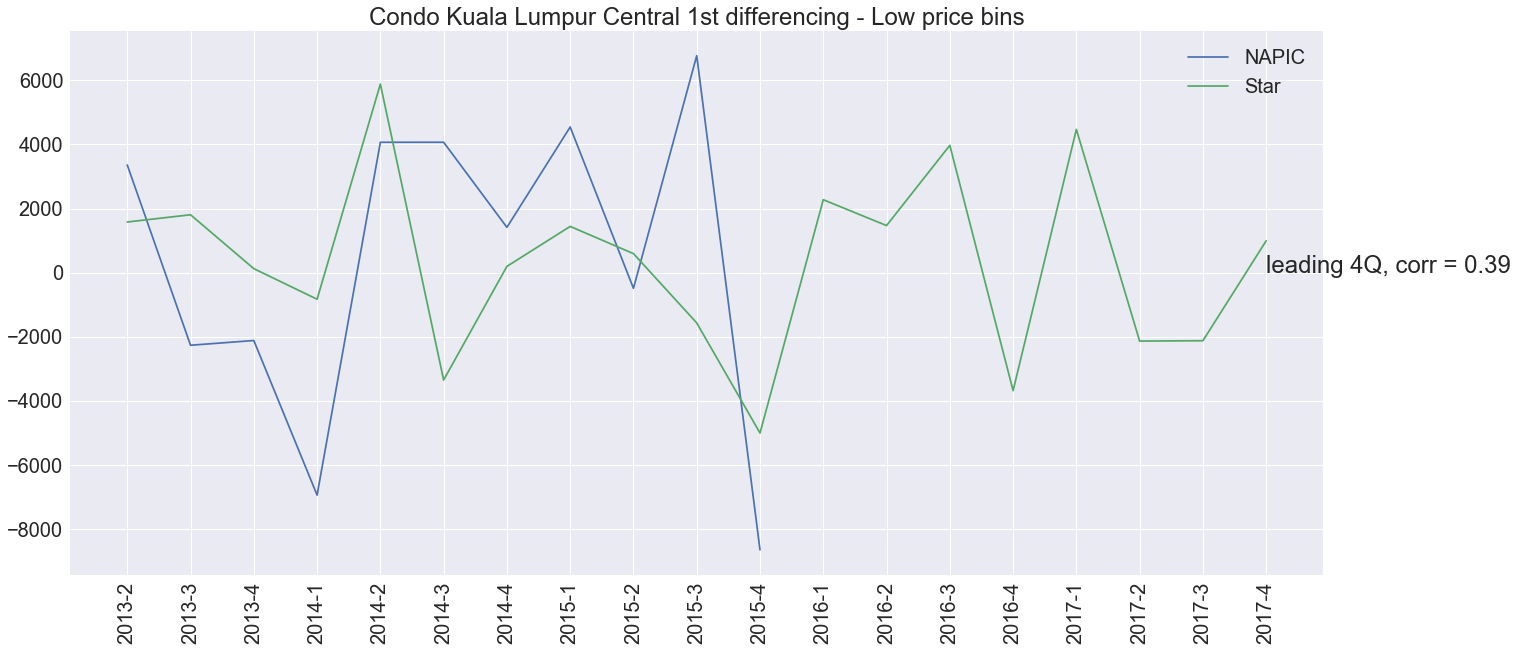

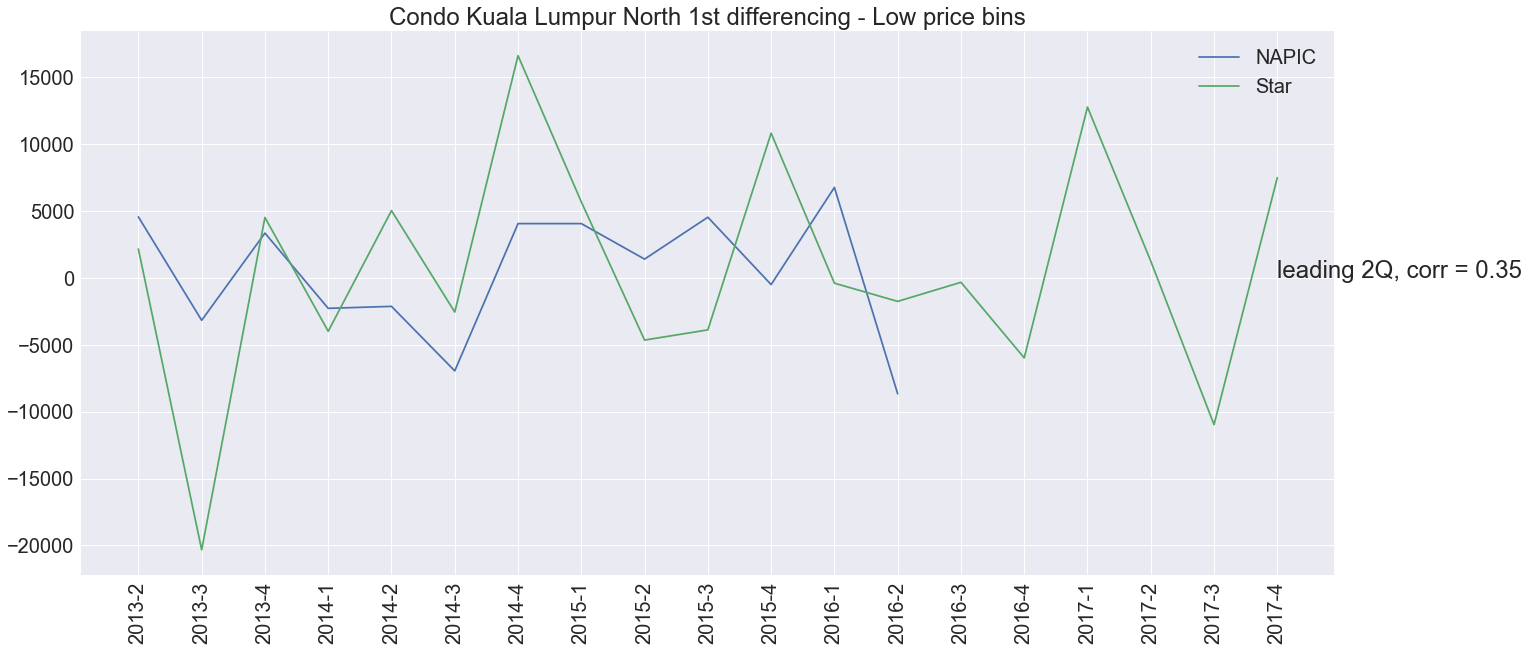

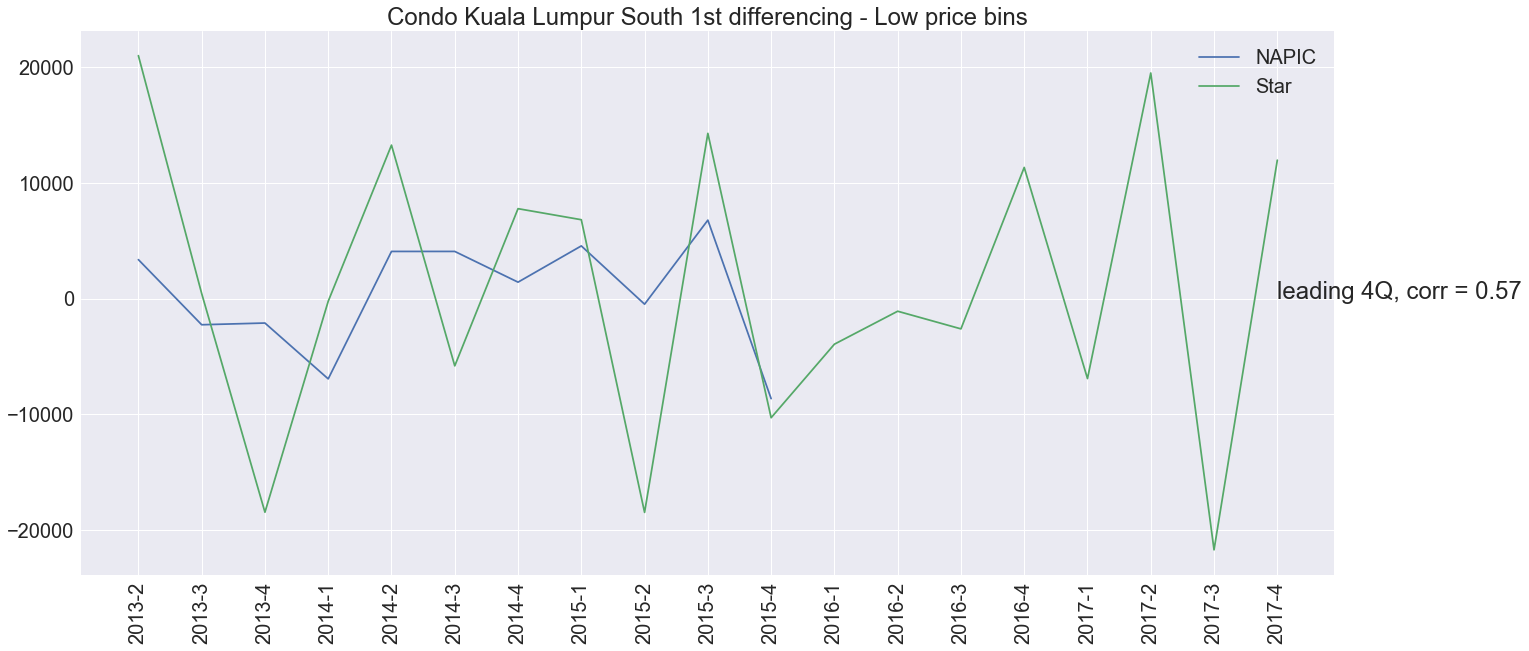

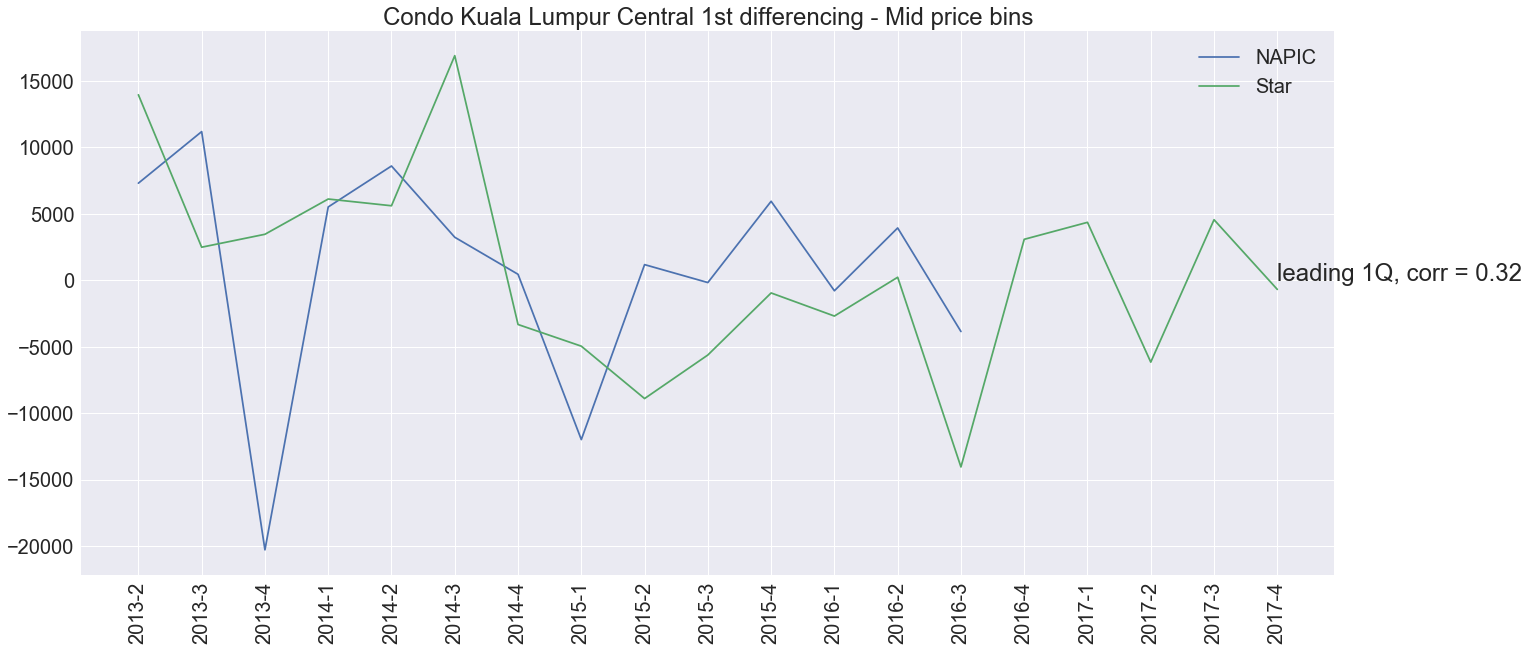

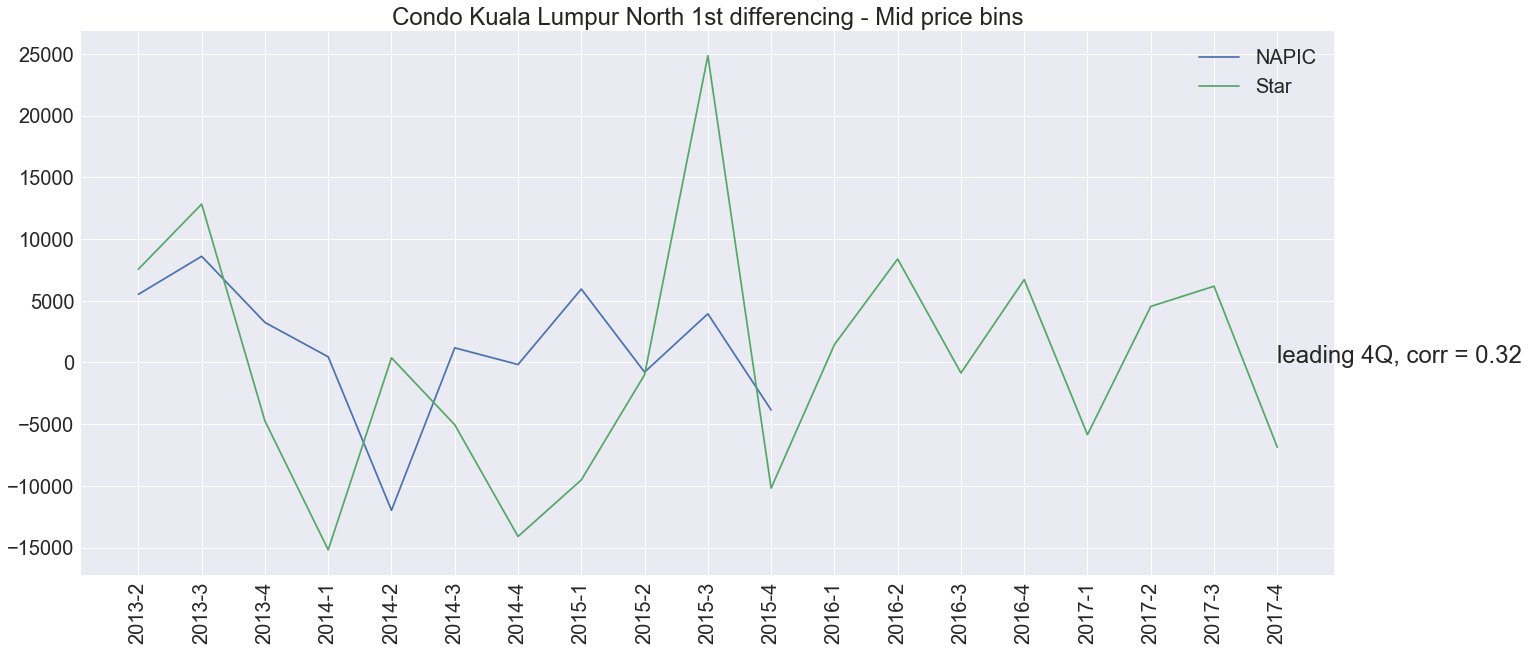

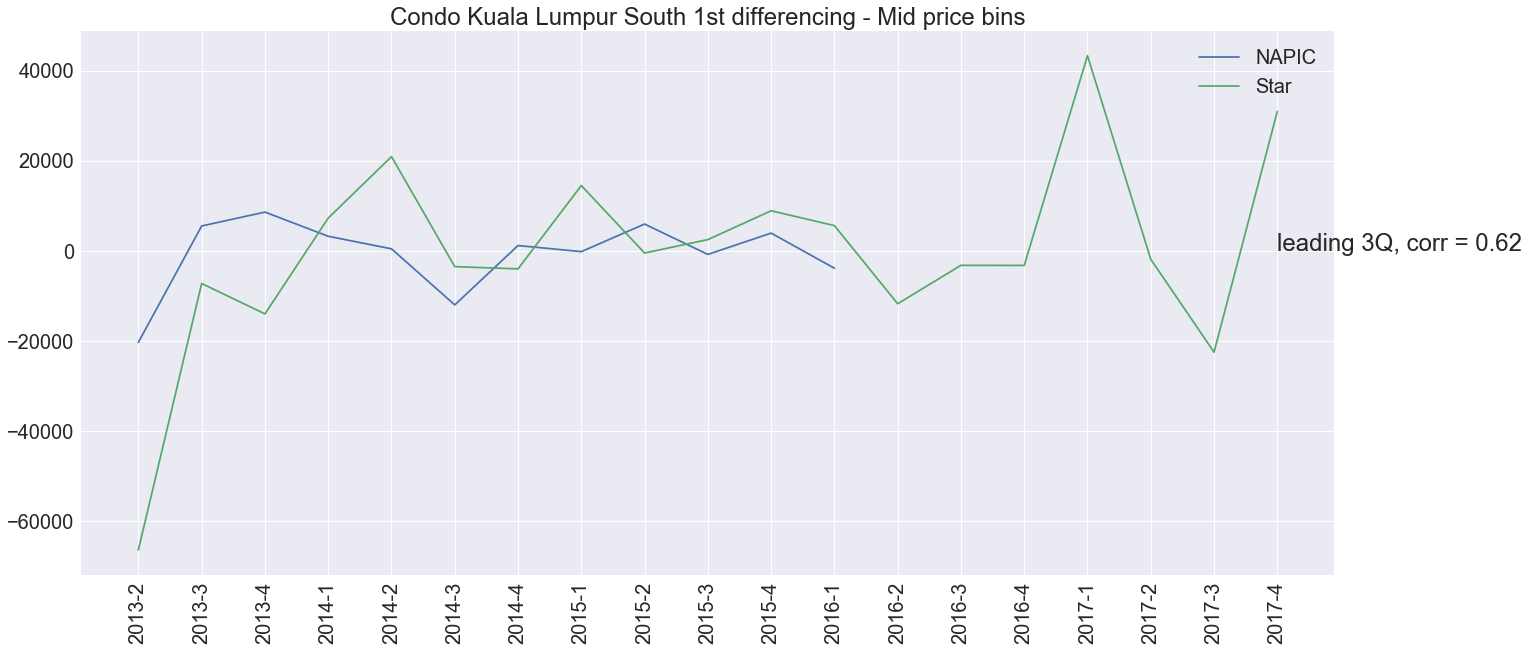

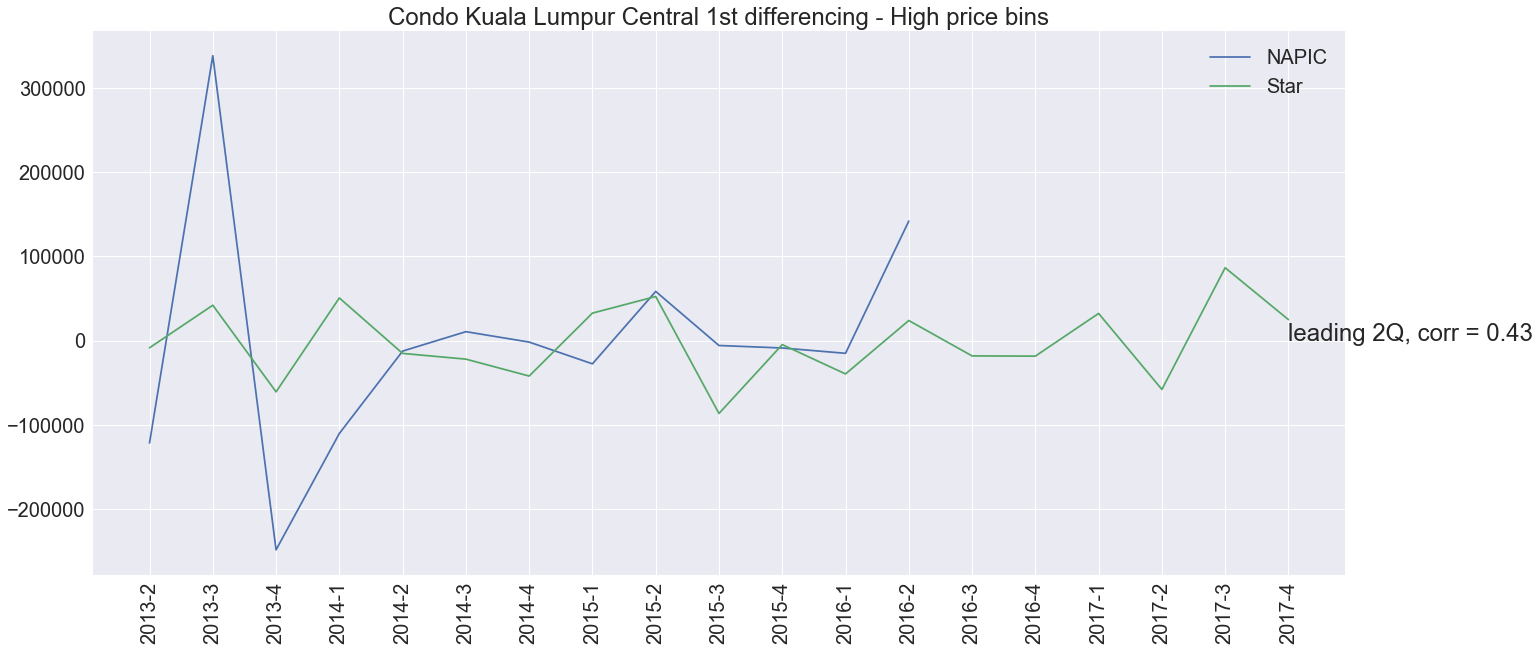

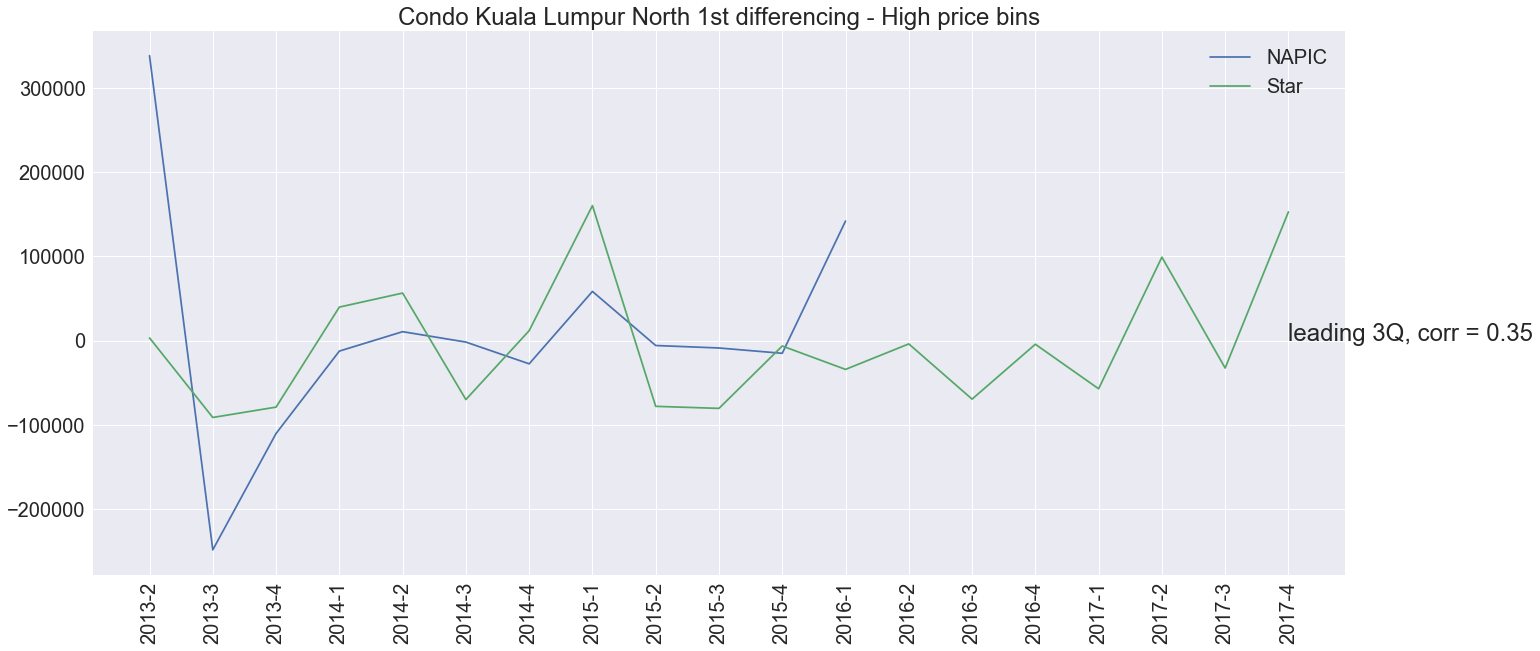

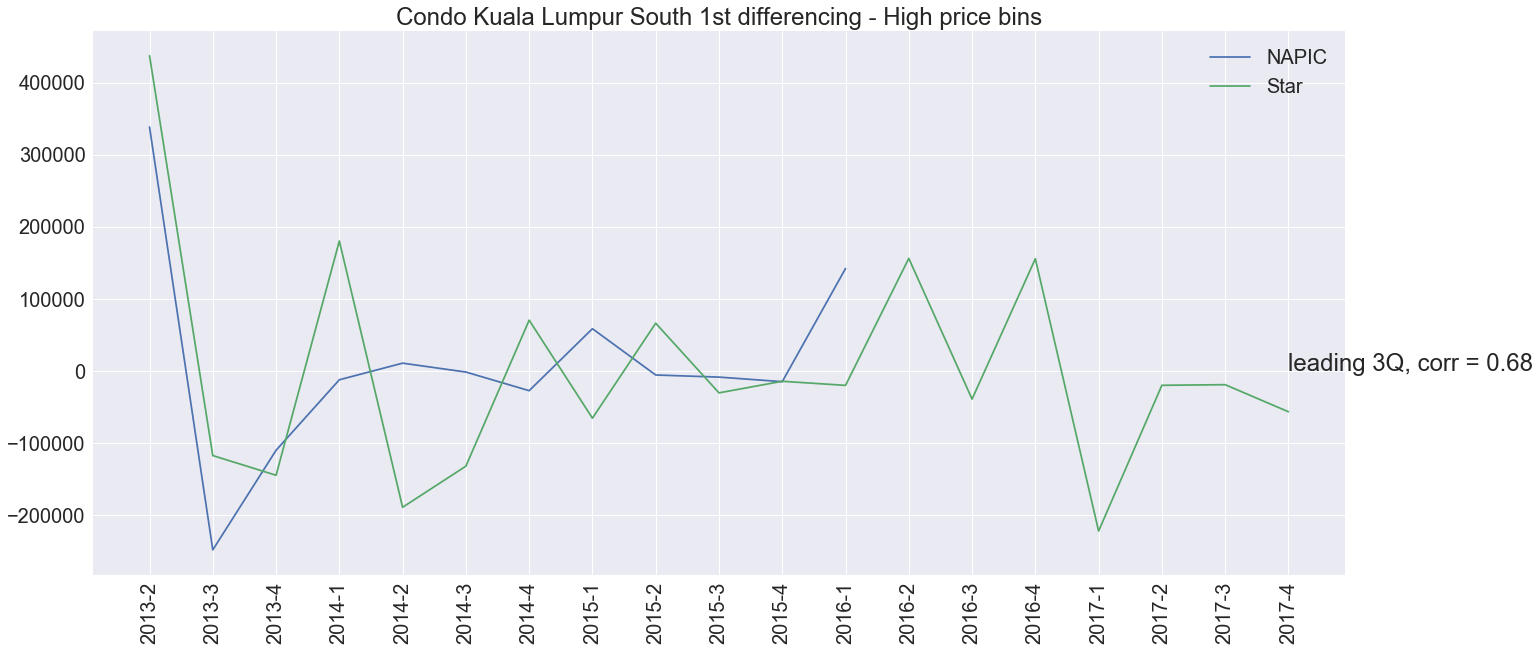

In [78]:
#Compare KL series - 1st differencing by area by price bins
#shift graph according to strongest correlation
sns.set(font_scale = 2)
for i in df_napicKL['price_bins'].unique():
    for j in [i for i in Combination_KL if i[1] == 'Low']:
        plt.figure(figsize = (20,10))
        NAPIC = df_napicKL_SecondMarket\
        [df_napicKL_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean().diff().dropna()
        Star = df_starKL_district[(df_starKL_district['price_bins'] == i)
                & (df_starKL_district['district_type'] == j[0])].groupby('year-quarter')['price'].mean().diff().dropna()
        order,correlation = crossCorr(Star,NAPIC)
        plt.plot(NAPIC.shift(-order),label = 'NAPIC')
        plt.plot(Star,label = 'Star')
        plt.legend()
        plt.xticks(rotation = '90')
        plt.title('Condo Kuala Lumpur {} 1st differencing - {} price bins'.format(j[0],i))
        plt.text('2017-4',0,'leading {}Q, corr = {}'.format(order,round(correlation,2)))
        plt.savefig('../graphs/Condo Kuala Lumpur {} 1st differencing - {} price bins.png'.format(j[0],i),
                   bbox_inches = 'tight')
        Star.to_frame().merge(NAPIC.shift(-order).to_frame(),left_index = True, right_index = True)\
        .to_excel('../data/excel/Condo Kuala Lumpur {} 1st differencing - {} price bins.xlsx'.format(j[0],i))

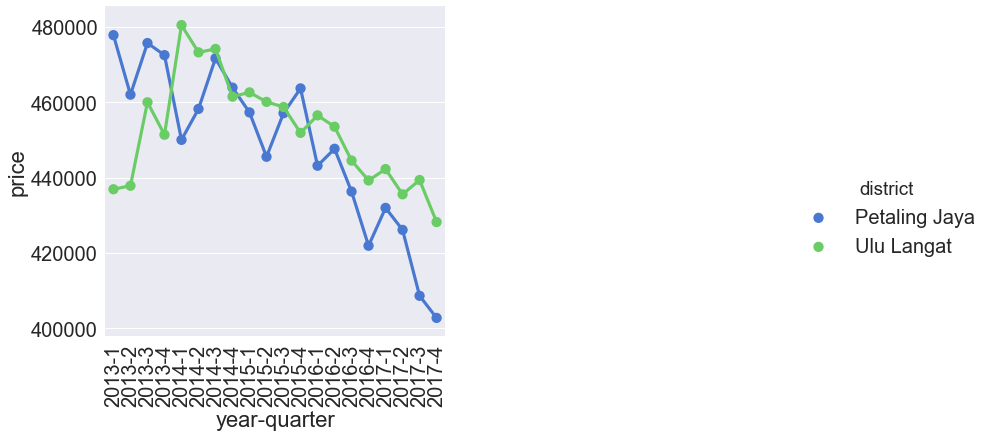

In [16]:
#plot mid price bin for all region - starSel condo
sns.set(font_scale = 2)
panda_list = []
for i in district:
    df_temp = df_starSel_district[(df_starSel_district['price_bins'] == 'Mid')&
                                (df_starSel_district['district_master'] == i)].groupby('year-quarter')['price'].mean().reset_index()
    df_temp['district'] = i
    panda_list.append(df_temp)
df_total = pd.concat(panda_list)
plt.figure(figsize = (20,10))
g = sns.factorplot(x = 'year-quarter', y = 'price', hue = 'district', data = df_total,
                 capsize=.2, palette="muted", size=6, aspect=.75)
g.fig.set_size_inches(20,6)
plt.xticks(rotation = '90')
df_total.to_excel('../data/excel/StarSel_Midpricebin_pricetrend.xlsx')   

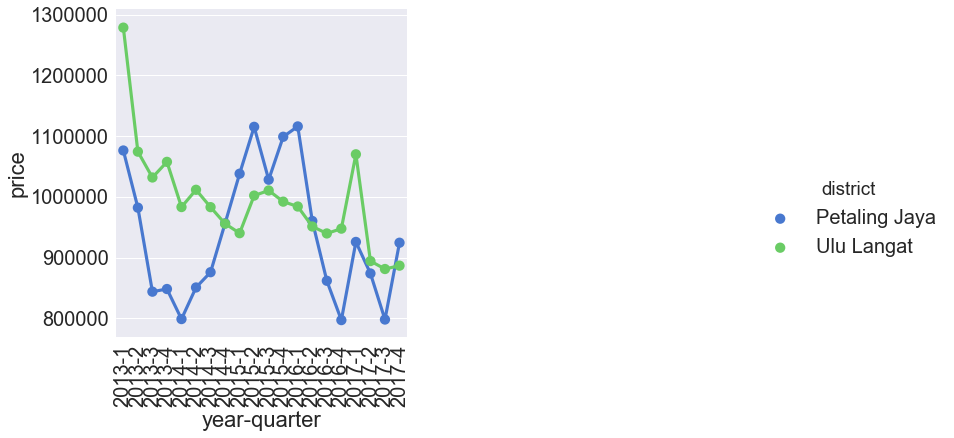

In [17]:
#plot high price bin for all region - starSel condo
sns.set(font_scale = 2)
panda_list = []
for i in district:
    df_temp = df_starSel_district[(df_starSel_district['price_bins'] == 'High')&
                                (df_starSel_district['district_master'] == i)].groupby('year-quarter')['price'].mean().reset_index()
    df_temp['district'] = i
    panda_list.append(df_temp)
df_total = pd.concat(panda_list)
plt.figure(figsize = (20,10))
g = sns.factorplot(x = 'year-quarter', y = 'price', hue = 'district', data = df_total,
                 capsize=.2, palette="muted", size=6, aspect=.75)
g.fig.set_size_inches(20,6)
plt.xticks(rotation = '90')
df_total.to_excel('../data/excel/StarSel_Highpricebin_pricetrend.xlsx')   

In [11]:
#groupby district and year-quarter
starSel_Bydistrict_quarter = df_starSel_district.groupby(['district_master','year-quarter'])['price'].mean().reset_index()\
                                                                            .values

tuple_Bydistrict_quarter = [(i[0],i[1],i[2]*(weightage_NAPICSel[i[0]]/100)) for i in starSel_Bydistrict_quarter]

d = defaultdict(list)
for i in [i for i in tuple_Bydistrict_quarter]:
    d[i[1]].append(i[2])
sum_averageprice = [(i,sum(j)) for i,j in d.items()]

#get Sel official data
df_NAPIC_Selofficial = pd.read_excel('../data/external/Seldistrict_highRise.xlsx')\
                        .rename(columns = {'Hulu Langat':'Ulu Langat'})

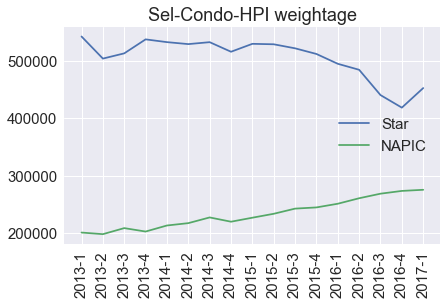

In [55]:
#Sel by year-quarter
sns.set(font_scale = 1.5)
index = [i[0] for i in sum_averageprice if i[0] not in ['2017-2','2017-3','2017-4']]
Star_series = pd.Series([i[1] for i in sum_averageprice if i[0] not in ['2017-2',
                                                                        '2017-3','2017-4']],name = 'Star',index = index)
NAPIC_series = pd.Series(df_NAPIC_Selofficial['Selangor'].iloc[12:].values,name = 'NAPIC',index = index)
plt.plot(Star_series,label = 'Star')
plt.plot(NAPIC_series,label = 'NAPIC')
plt.legend()
plt.title('Sel-Condo-HPI weightage')
plt.savefig('Sel-Condo-HPI weightage.png',bbox_inches = 'tight')
plt.xticks(rotation = '90')
Star_series.to_frame().merge(NAPIC_series.to_frame(),left_index = True, right_index = True)\
.to_excel('../data/excel/Comparison_SelCondo_HPIweightage.xlsx')

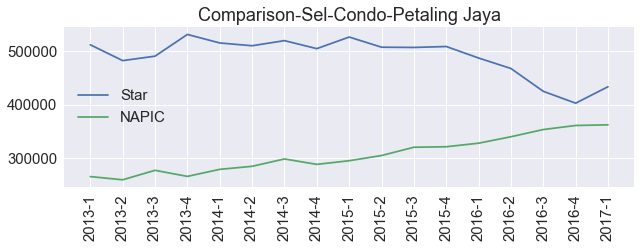

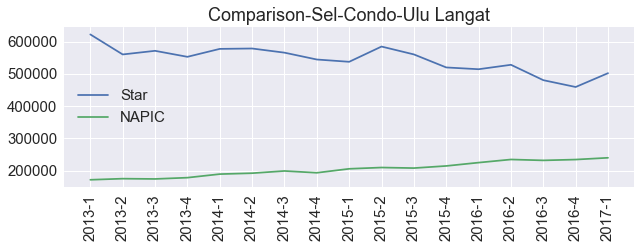

In [56]:
sns.set(font_scale = 1.5)
tuple_Bydistrict_quarter = [(i[0],i[1],i[2]) for i in starSel_Bydistrict_quarter]
for no,region in enumerate(['Petaling Jaya','Ulu Langat']):
    plt.figure(figsize = (20,10))
    plt.subplot(3,2,no+1)
    starPeriod_list = [i for i in df_starSel['year-quarter'].unique() if i not in ['2017-2','2017-3','2017-4']]
    Star = pd.Series([i[2] for i in [i for i in tuple_Bydistrict_quarter if i[1] in starPeriod_list] 
                        if i[0] == region], index = starPeriod_list)
    NAPIC = pd.Series(df_NAPIC_Selofficial['{}'.format(region)].iloc[12:].values,
                         index = starPeriod_list)
    plt.plot(Star,label = 'Star')
    plt.plot(NAPIC,label = 'NAPIC')
    plt.legend()
    plt.xticks(rotation = '90')
    plt.title('Comparison-Sel-Condo-{}'.format(region))
    plt.savefig('../graphs/Comparison-Sel-Condo-{}.png'.format(region),bbox_inches = 'tight')
    Star.to_frame().merge(NAPIC.to_frame(),right_index = True, left_index = True)\
    .to_excel('../data/excel/Comparison-Sel-Condo-{}.xlsx'.format(region))

In [64]:
df_starSel_district

Unnamed: 0         Type                            Location  \
174           1701  Condominium                                 NaN   
349           3451  Condominium                                 NaN   
409           4092  Condominium                                 NaN   
410           4107  Condominium                                 NaN   
468           4672  Condominium                                 NaN   
520           4933  Condominium                                 NaN   
573           5446  Condominium                                 NaN   
616           6000  Condominium               Hulu Langat, Selangor   
666           6702  Condominium                                 NaN   
715           7288  Condominium                                 NaN   
802           8356  Condominium                                 NaN   
861           9129  Condominium                                 NaN   
862           9136  Condominium                                 NaN   
1144         12505  Condominium                                 NaN   
1163         12690  Condominium                                 NaN   
1226         13433  Condominium                                 NaN   
1409         15449  Condominium                                 NaN   
1535         17016  Condominium                                 NaN   
1564         17344  Condominium                                 NaN   
1575         17402  Condominium                                 NaN   
1608         17739  Condominium                                 NaN   
1609         17740  Condominium                                 NaN   
1672         18349  Condominium                                 NaN   
1749         19104  Condominium                                 NaN   
1792         19495  Condominium                                 NaN   
1986         21155  Condominium                                 NaN   
2090         22503  Condominium                                 NaN   
2178         23335  Condominium                                 NaN   
2191         23585  Condominium                                 NaN   
2218         23888  Condominium                                 NaN   
...            ...          ...                                 ...   
559123     4482850  Condominium                                 NaN   
559159     4483358  Condominium                                 NaN   
559176     4483473  Condominium                                 NaN   
559186     4483528  Condominium                                 NaN   
559212     4483798  Condominium                                 NaN   
559226     4483966  Condominium                                 NaN   
559239     4484083  Condominium                                 NaN   
559240     4484084  Condominium                                 NaN   
559252     4484221  Condominium                                 NaN   
559291     4484697  Condominium                                 NaN   
559323     4485056  Condominium  Bandar Damai Perdana, Cheras South   
559378     4485679  Condominium                                 NaN   
559405     4485918  Condominium  Bandar Damai Perdana, Cheras South   
559424     4486039  Condominium                                 NaN   
559431     4486119  Condominium                                 NaN   
559435     4486126  Condominium                                 NaN   
559441     4486236  Condominium  Bandar Damai Perdana, Cheras South   
559447     4486293  Condominium                                 NaN   
559466     4486516  Condominium                                 NaN   
559482     4486654  Condominium                                 NaN   
559492     4486752  Condominium                                 NaN   
559499     4486786  Condominium                                 NaN   
559500     4486787  Condominium                                 NaN   
559505     4486814  Condominium  Bandar Damai Perdana, Cheras South   
559506     4486824  Condominium 

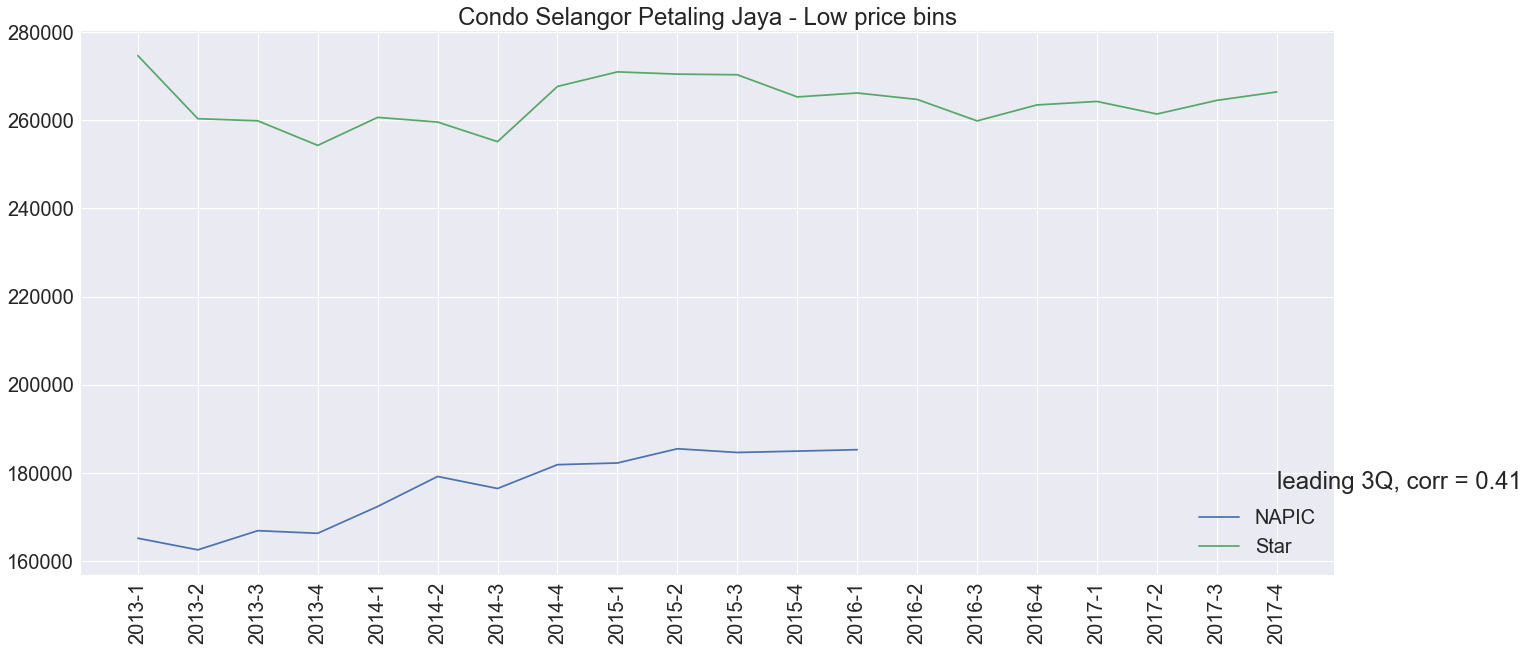

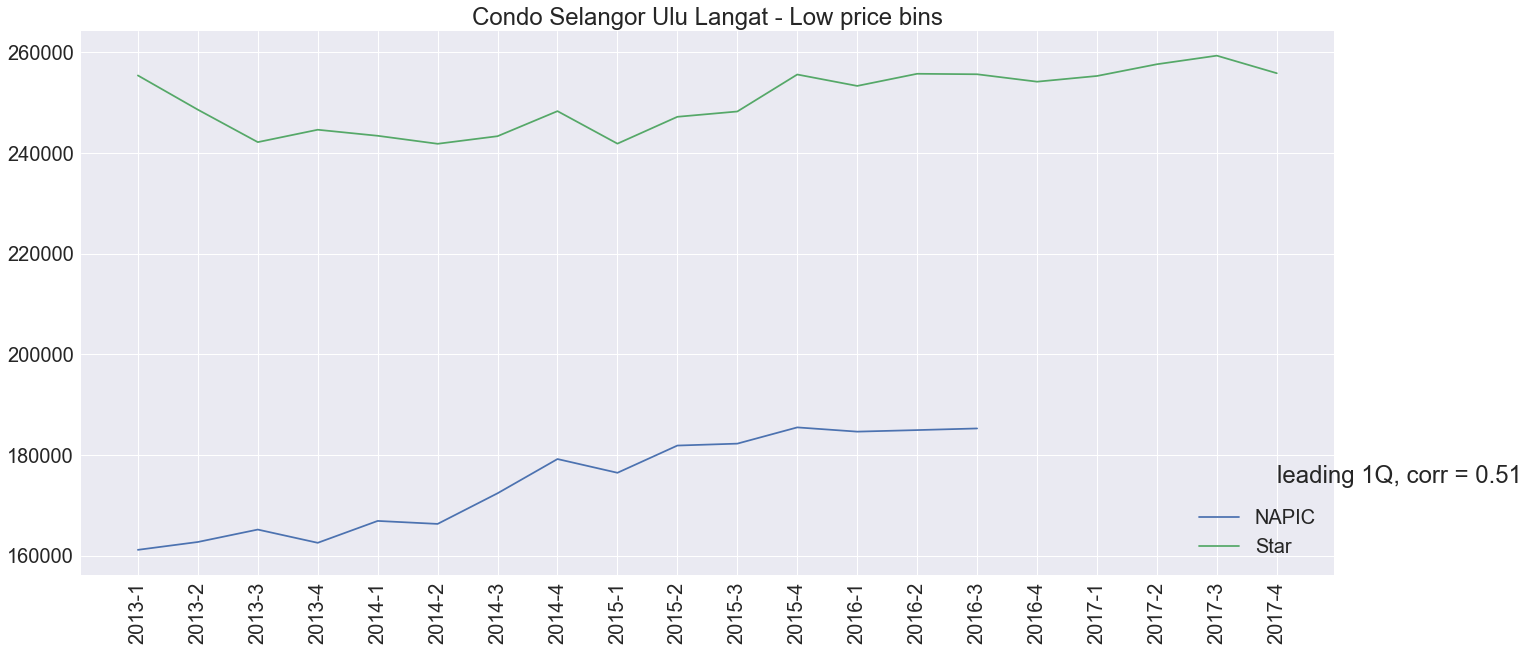

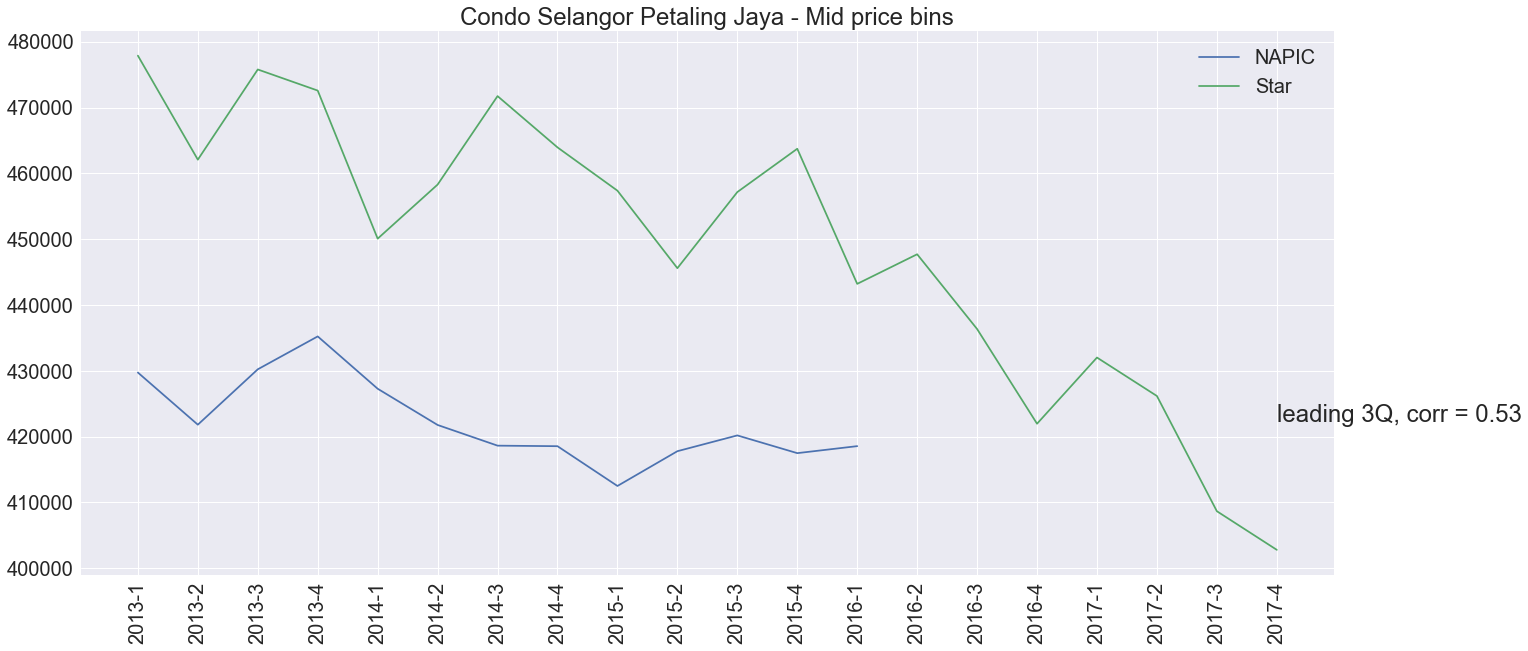

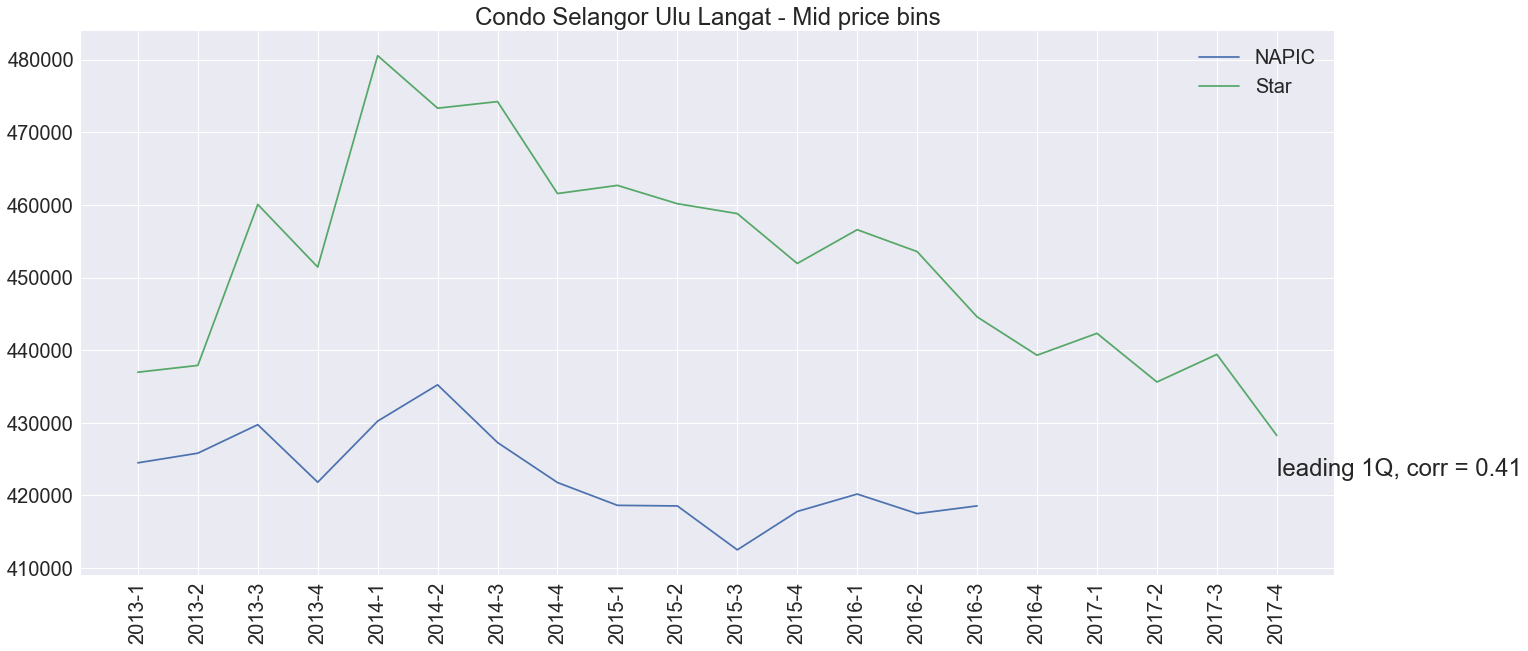

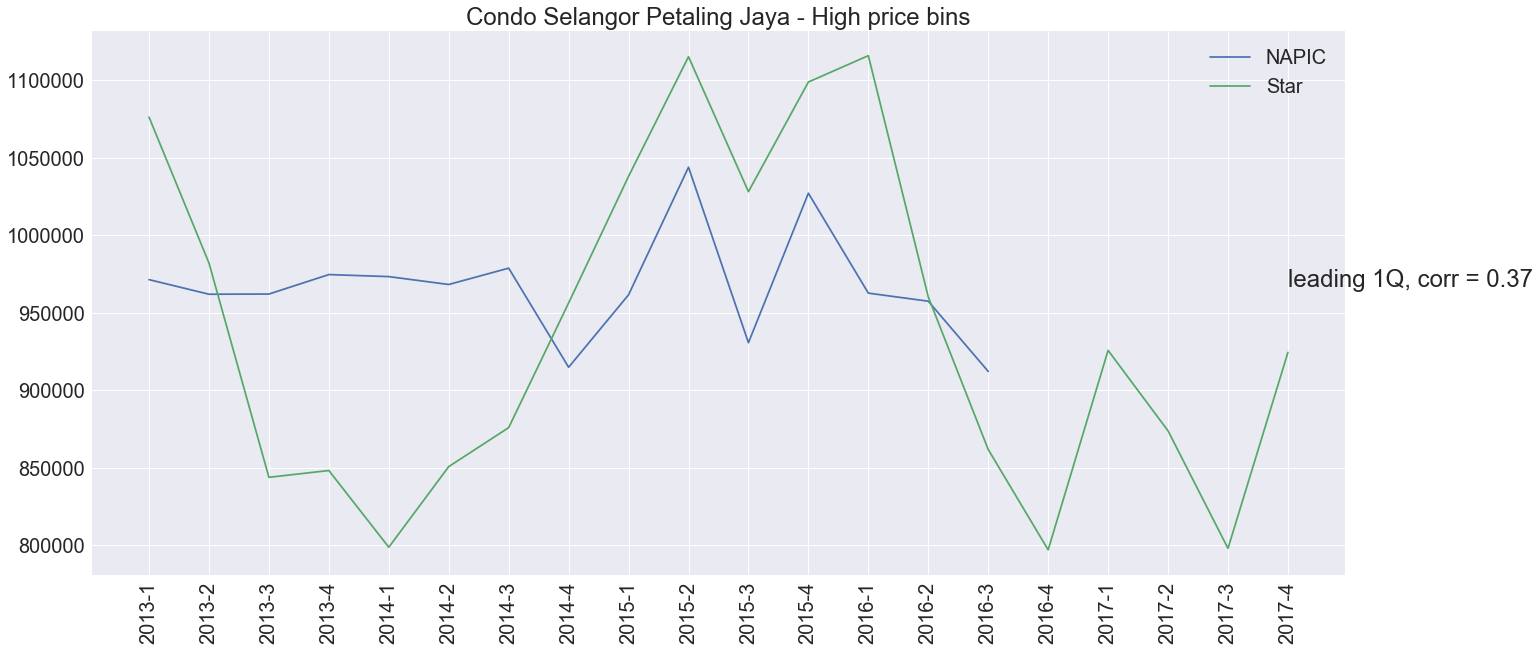

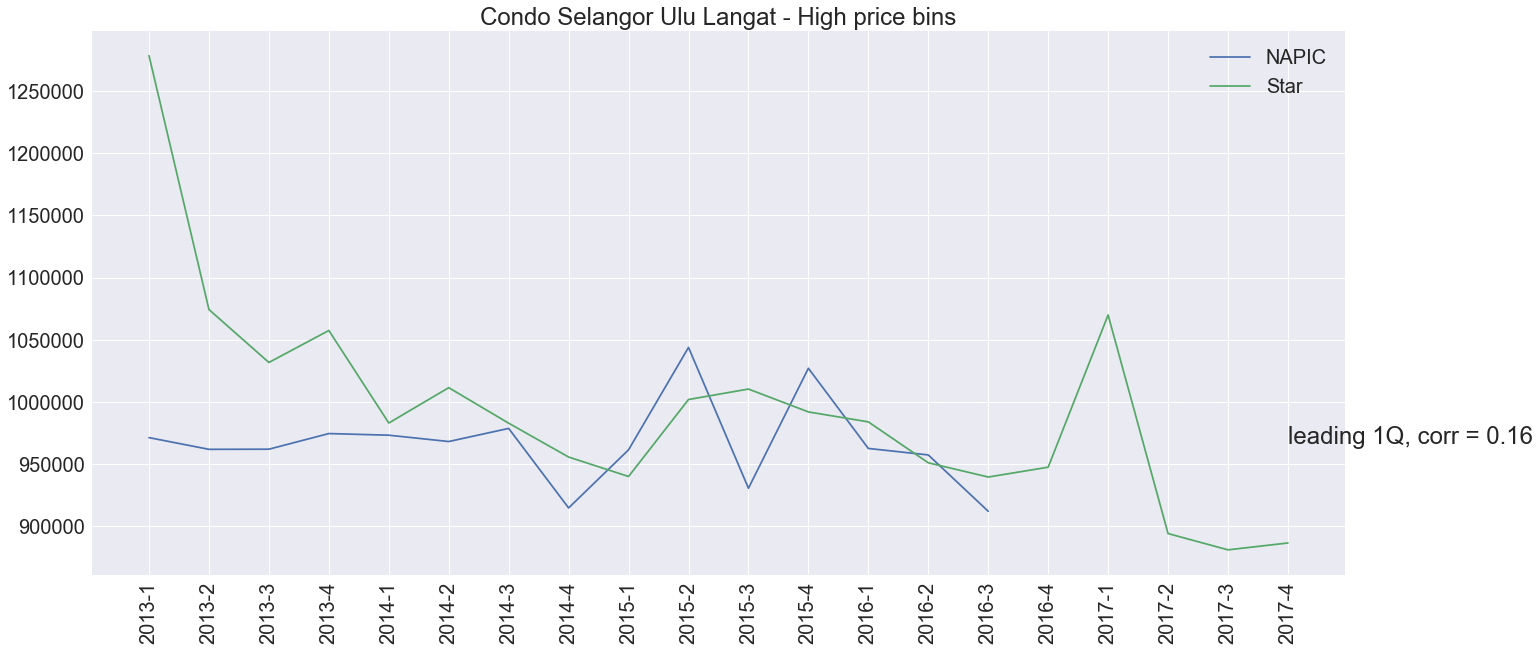

In [20]:
#Compare KL series by area by price bins
sns.set(font_scale = 2)
for i in df_napicSel['price_bins'].unique():
    for j in [i for i in Combination_Sel if i[1] == 'Low']:
        plt.figure(figsize = (20,10))
        NAPIC = df_napicSel_SecondMarket\
        [df_napicSel_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean()
        Star = df_starSel_district[(df_starSel_district['price_bins'] == i)
                & (df_starSel_district['district_master'] == j[0])].groupby('year-quarter')['price'].mean()
        order,correlation = crossCorr(Star,NAPIC)
        plt.plot(NAPIC.shift(-order),label = 'NAPIC')
        plt.plot(Star,label = 'Star')
        plt.legend()
        plt.xticks(rotation = '90')
        plt.title('Condo Selangor {} - {} price bins'.format(j[0],i))
        plt.text('2017-4',np.mean(df_napicSel_SecondMarket
                 [df_napicSel_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean()
                 .shift(-order).dropna()),'leading {}Q, corr = {}'.format(order,round(correlation,2)))
        plt.savefig('../graphs/Condo Selangor {} - {} price bins.png'.format(j[0],i),
                   bbox_inches = 'tight')
        Star.to_frame().merge(NAPIC.shift(-order).to_frame(),left_index = True, right_index = True)\
        .to_excel('../data/excel/Condo Selangor {} - {} price bins.xlsx'.format(j[0],i))

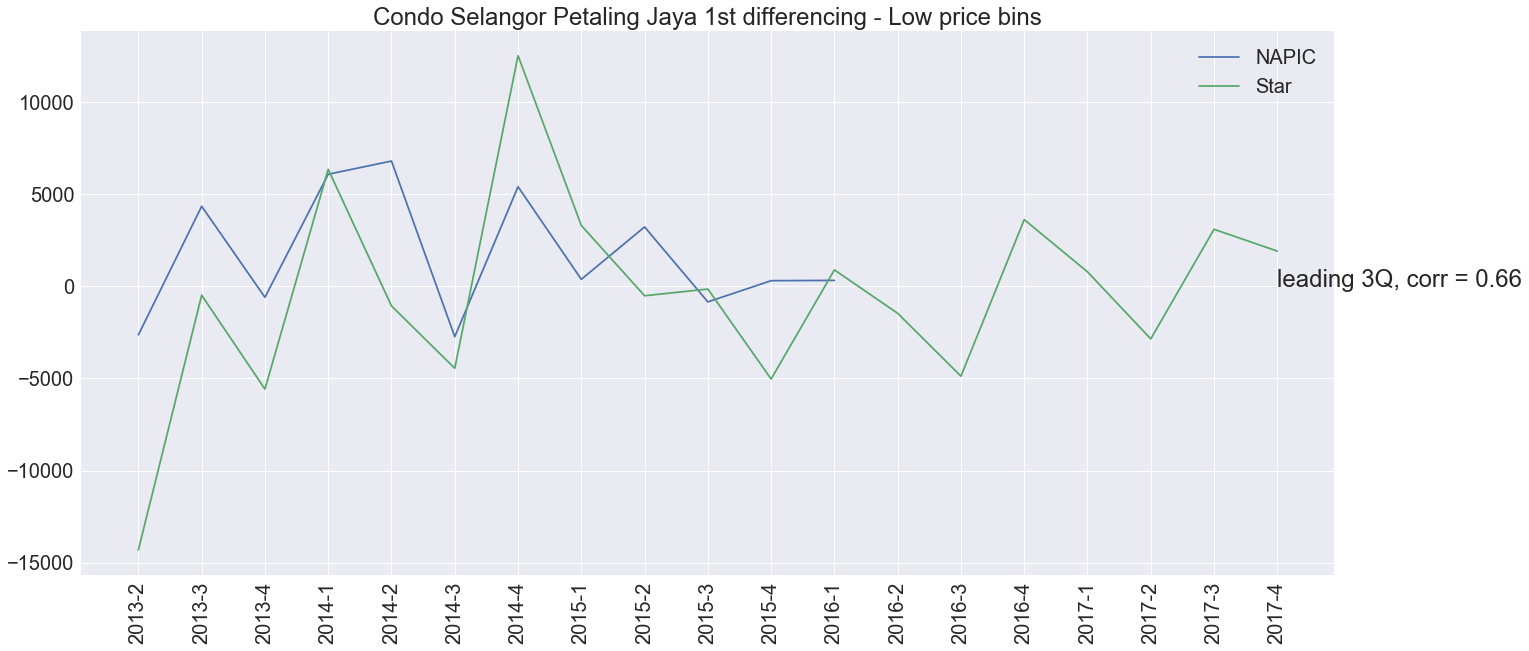

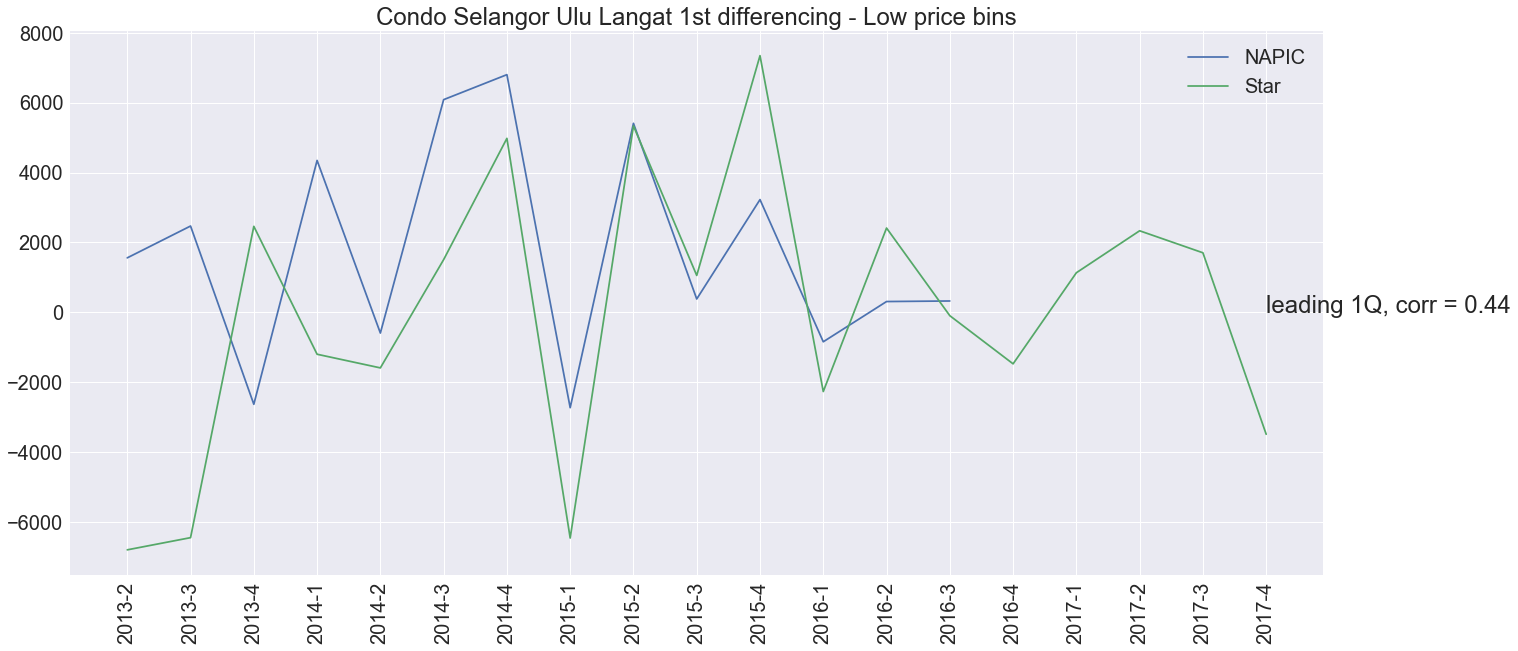

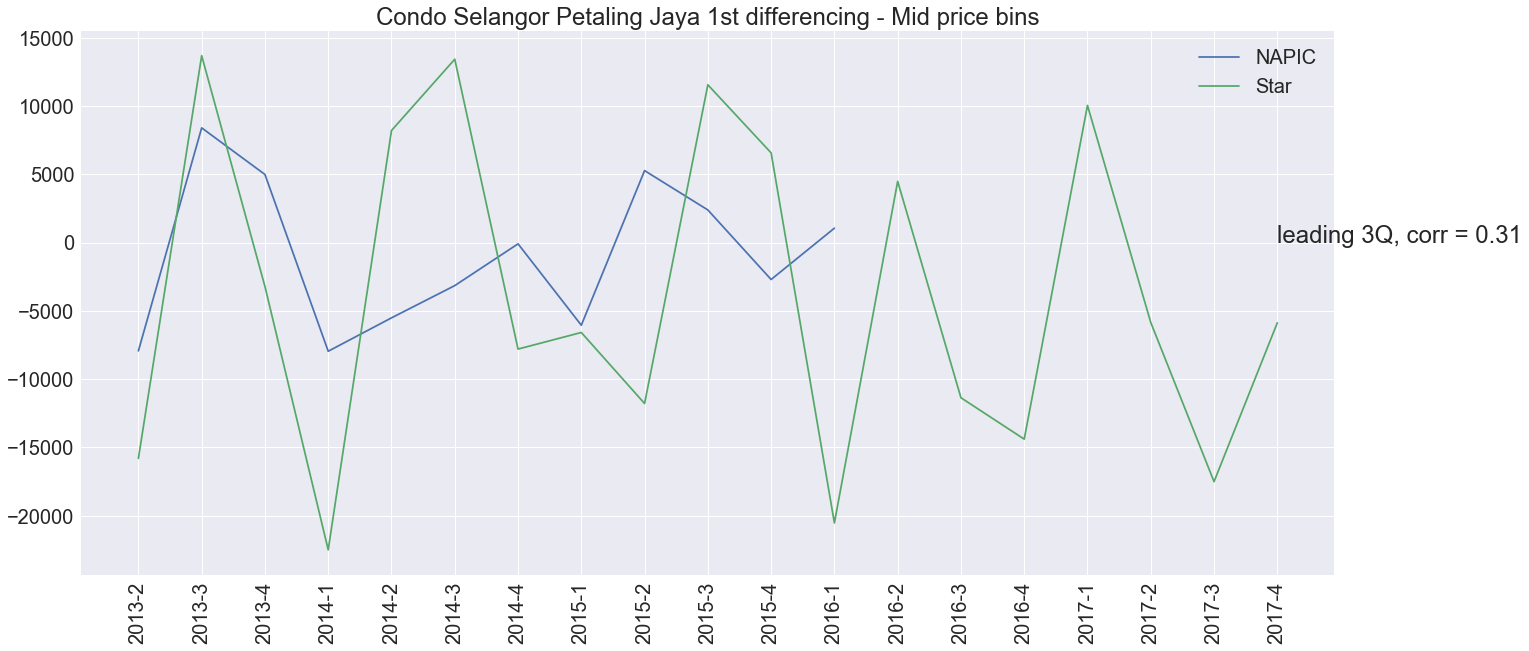

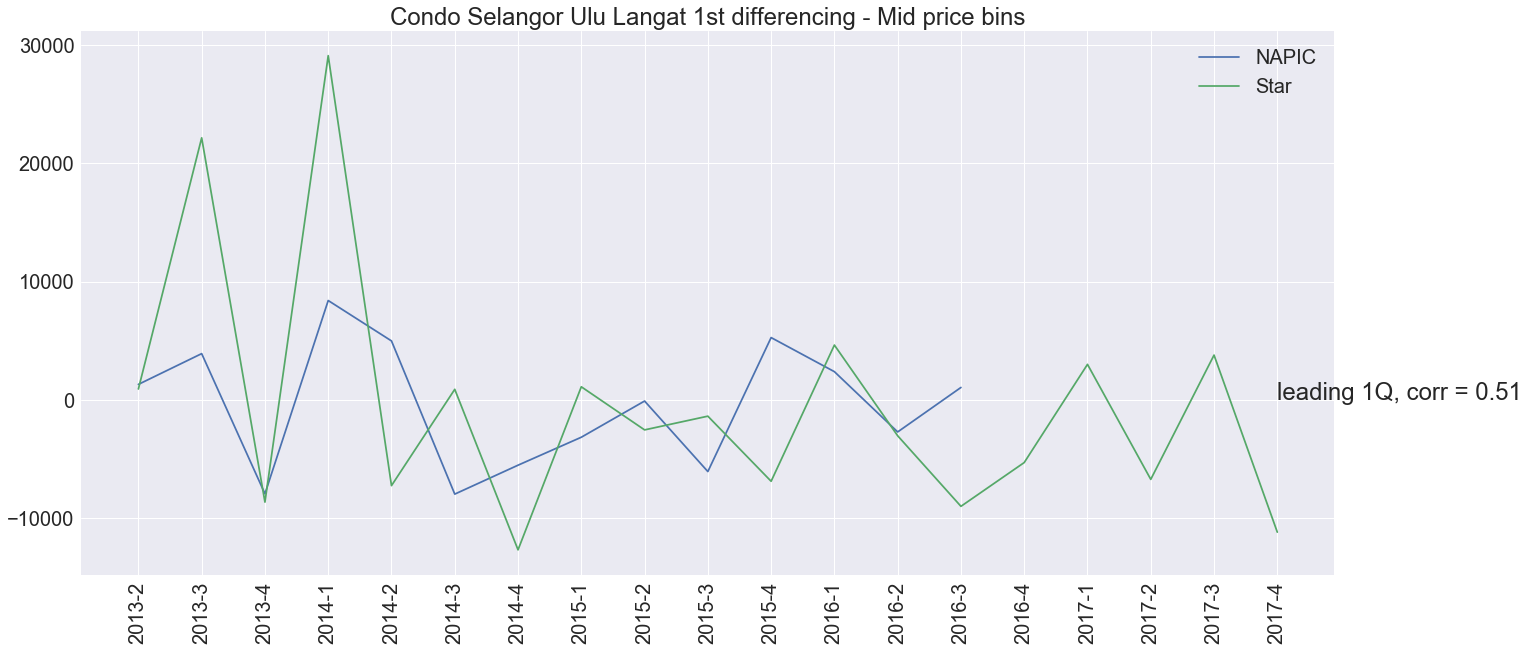

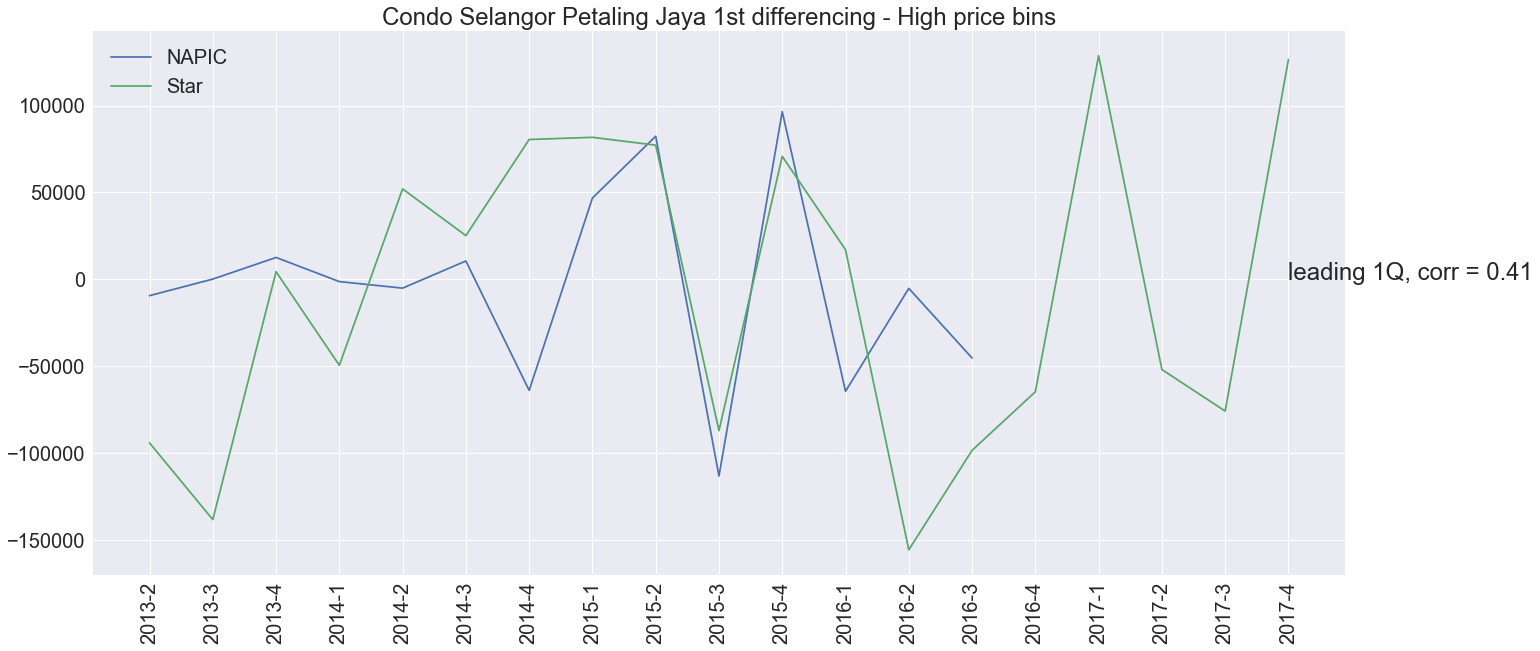

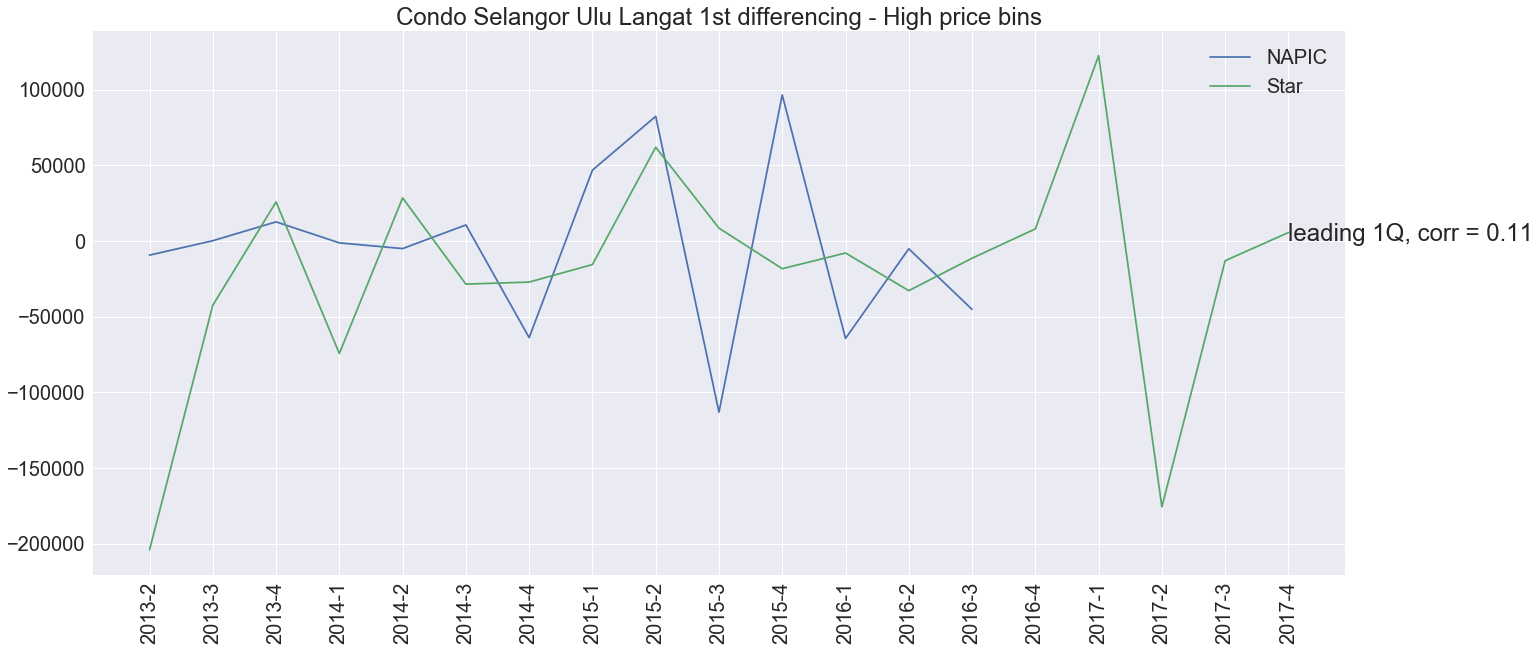

In [19]:
sns.set(font_scale = 2)
for i in df_napicKL['price_bins'].unique():
    for j in [i for i in Combination_Sel if i[1] == 'Low']:
        plt.figure(figsize = (20,10))
        NAPIC = df_napicSel_SecondMarket\
        [df_napicSel_SecondMarket['price_bins'] == i].groupby('year-quarter')['HARGA_B'].mean().diff().dropna()
        Star = df_starSel_district[(df_starSel_district['price_bins'] == i)
                & (df_starSel_district['district_master'] == j[0])].groupby('year-quarter')['price'].mean().diff().dropna()
        order,correlation = crossCorr(Star,NAPIC)
        plt.plot(NAPIC.shift(-order),label = 'NAPIC')
        plt.plot(Star,label = 'Star')
        plt.legend()
        plt.xticks(rotation = '90')
        plt.title('Condo Selangor {} 1st differencing - {} price bins'.format(j[0],i))
        plt.text('2017-4',0,'leading {}Q, corr = {}'.format(order,round(correlation,2)))
        plt.savefig('../graphs/Condo Selangor {} 1st differencing - {} price bins.png'.format(j[0],i),
                   bbox_inches = 'tight')
        Star.to_frame().merge(NAPIC.shift(-order).to_frame(),left_index = True, right_index = True)\
        .to_excel('../data/excel/Condo Selangor {} 1st differencing - {} price bins.xlsx'.format(j[0],i))